<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code was written by Ian Davis  (textserver.com@gmail.com, 12 Feb 2020) for Lecture 14 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Comments, concerns, questions, improvements or requests for explanation encouraged.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: Quantum Computing, An Applied Approach by Jack D. Hidary (2019)


# Grover's Quantum Search Algorithm

If |a> and |b> are any two normalized vectors then their inner product &lt;a|b> is the cosine of the angle θ between them.  The **defining** characteristic of a unitary matrix/transformation is that it preserves inner products.  Thus applying a unitary matrice U to |a> and |b> produces a new pair of vectors |Ua> and |Ub> that differ by the same angle θ. That is &lt;aU|Ub> = &lt;a|b> = θ.  Thus U$^{†}$U = I.

All quantum operations except measurement are unitary.  Since all such operations thus preserve the angles between all vectors in the vector space being operated on, they can do no more than rotate that vector space. However, if |a> = |a$_{1}$> + |a$_{2}$> with |a$_{1}$> and |a$_{2}$> belonging to distinct subspaces of |a> a unitary U may still change the angle between |a$_{1}$> and |a$_{2}$>.  This is what Grover's algorithm does.

Grover's algorithm is an amplitude amplification algorithm which at each iteration rotates the amplitude of some unknown value *x* or values (flagged by an interal quantum oracle) by a fixed angle towards its maximum |amplitude|.  This rotation is achieved by negating the amplitudes of all flagged values (which is equivalent to rotating these amplitudes about the x-axis) followed by a rotation of all amplitudes about their collective mean amplitude.

If there is a single marked value *x* and *n* values in total after *(π/4)√n* rotations the amplitude of *x* will be close to it's maximum amplitude. This is because the mean is initially *1/√n*, each rotation of *x* is by *2/√n* below and then above that mean, and the change in the amplitude of *x* (rotations being fixed) must be a sine wave, and is thus maximal when the rotations sum to *(π/2) = (2/√n)×(π/4)√n*, presuming the original mean *1/√n ≅ 0*. Further iterations will then rotate this amplitude away from this maximum amplitude.  By measuring the quantum state when this amplitude is closest to its maximal value, we ensure that the hidden value *x* will be measured with high probability.

When *m* values are flagged, all hidden values are amplified in parallel.  This significantly increases the angle of rotation at each step.  Amplitudes are consequently now first maximal after approximately *(π/4)√(n/m)* rotations. If *m* is unknown, the challenge is to decide how many iterations of the search algorithm should be performed before measurement.

When zero or all values are flagged no amplitude amplification occurs. When more than 1/2 the values are flagged, the desired number of iterations should be chosen so that unmarked amplitudes become very close to zero.  This is the better description of the algorithm's true objective.

In [ ]:
# install cirq
!pip install cirq --quiet
import sys
import cirq
import numpy
import math
import random

from cirq.contrib.svg import circuit_to_svg
from IPython.display import SVG, display
import io

%matplotlib inline
import matplotlib.pyplot

print('Installed python ', sys.version, '\ncirq ', cirq.__version__)

Installed python  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] 
cirq  0.7.0


## Functions used

In [ ]:
#@title
input_qubits     = 10
ancillary_qubits = 0
input_values     = 2**input_qubits
hidden_values    = []
num_values       = 1

oracle_unitary      = []
oracle_size         = 0
householder_unitary = []
householder_size    = 0

class color:
   PURPLE    = '\033[95m'
   CYAN      = '\033[96m'
   DARKCYAN  = '\033[36m'
   BLUE      = '\033[94m'
   GREEN     = '\033[92m'
   YELLOW    = '\033[93m'
   RED       = '\033[91m'
   BOLD      = '\033[1m'
   UNDERLINE = '\033[4m'
   END       = '\033[0m'

# Defining a function to print/output circuits in a clean way
# Lifted from earlier code. Originally suggested by Nadine. 
# Avoids using temporary files
def svgprint(circuit):
    out = io.StringIO()
    out.write(circuit_to_svg(circuit))
    display(SVG(out.getvalue()))

# Show a green tick mark as an icon
def yes_answer():
    display(SVG("""<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" width="64px" height="64px"
 viewbox="0 0 800 800">
<defs>
<radialGradient id="rg" cx="50%" cy="50%" r="50%">
<stop stop-color="#080" offset="0"/>
<stop stop-color="#050" offset="1"/>
</radialGradient></defs>
<path d="m7.7,404.6c0,0 115.2,129.7 138.2,182.68l99,0c41.5-126.7 202.7-429.1 340.92-535.1c28.6-36.8-43.3-52-101.35-27.62-87.5,36.7-252.5,317.2-283.3,384.64-43.7,11.5-89.8-73.7-89.84-73.7z" fill="url(#rg)"/>
</svg>
"""
))

# Show a red X as an icon
def no_answer():
    display(SVG("""<?xml version="1.0" encoding="utf-8"?>
<!-- Generator: Adobe Illustrator 14.0.0, SVG Export Plug-In . SVG Version: 6.00 Build 43363)  -->
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
	 width="64px" height="64px" viewBox="0 0 450 450" enable-background="new 0 0 450 450" xml:space="preserve">
<circle fill="#CC3333" cx="225" cy="225" r="225"/>
<g>
	<line fill="#FFFFFF" stroke="#FFFFFF" stroke-width="70" x1="106.742" y1="110.083" x2="343.258" y2="346.599"/>
	<line fill="#FFFFFF" stroke="#FFFFFF" stroke-width="70" x1="106.742" y1="346.599" x2="343.258" y2="110.084"/>
</g>
</svg>"""
))

# Construct the desired set of hidden values
def assign_hidden_values(hidden_values):
    global num_values, input_values

    elements      = 0
    while elements < num_values:
        value = random.randint(0,input_values-1)
        if not value in hidden_values:
            hidden_values.append(value)
            elements += 1
    return

# Apply a Hadamard on every line thus assigning all values equal amplitude
def set_same_amplitudes(gates):
    global input_qubits, qubits
    
    for qubit in range(input_qubits):
        gates.append(cirq.H(qubits[qubit]))

# Implement the gate that negates the amplitudes of all hidden values
class OracleGate(cirq.MatrixGate):
    def __init__(self):
        global oracle_unitary, oracle_size, input_values

        if oracle_size != input_values:
            # Only create this once to save space
            # Pity can't say dtype=int8
            oracle_unitary = numpy.ndarray(shape=(input_values,input_values))
            oracle_unitary.fill(0)
            oracle_size = input_values

        for row in range(input_values):
            oracle_unitary[row][row] = 1
        for index in range(num_values):
            value = hidden_values[index]
            oracle_unitary[value][value] = -1
        super().__init__(oracle_unitary)

    def num_qubits() -> int:
        return input_qubits

    def negate(self):
        global oracle_unitary, input_values

        for row in range(input_values):
            oracle_unitary[row][row] *= -1

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of arguments is significant
        return False

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        global hidden_values, input_qubits
        
        info = []
        if len(hidden_values) == 0:
            for index in range(input_qubits):
                info.append('I')
        elif len(hidden_values) == 1:
            value = hidden_values[0]
            for index in range(input_qubits):
                if value & (1 << (input_qubits-index-1)):
                    info.append('Z')
                else:
                    info.append('O')
        else:
            for index in range(input_qubits):
                info.append('O')
             
        return cirq.protocols.CircuitDiagramInfo(
            info,
            exponent=1)

    def __repr__(self) -> str:
        return 'Oracle'
 
    def __str__(self) -> str:
        return 'Oracle'

# Implement the gate that reflects all amplitudes about their mean amplitude

# To explain this gate let A be the matrix operation which when applied to any vector u produces Au = v
# where v contains in every element the average of the values in u.  Then A is a square non-unitary matrix
# with dimension n x n that contains 1/n in every element.

# To reflect u about the average v compute u - v which gives the separation of each element in u from the mean in v,
# and then compute v – (u - v) which reflects the elements of u about this mean value. 
# Equivalently, compute Au  – (u - Au) = (2A – I)u = Du. 
#
# Thus D[i][j] =((2/n)-1) when i=j and (2/n) otherwise.
#
# Since ((2/n)-1)^2+(n-1)(2/n)^2=1 and 2((2/n)-1)(2/n)+(n-2)(2/n)^2=0  remarkably D is unitary.  

class HouseholderGate(cirq.MatrixGate):
    def __init__(self):
        global householder_unitary, householder_size

        if householder_size != input_values:
            # Only create as needed to save space
            value = 2.0 / input_values
            householder_unitary = numpy.ndarray(shape=(input_values, input_values))
            
            for row in range(input_values):
                for col in range(input_values):
                    householder_unitary[row][col] = value
                    if row == col:
                        householder_unitary[row][col] -= 1.0
            householder_size = input_values

        super().__init__(householder_unitary)

    def num_qubits() -> int:
        return input_qubits

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of arguments is significant
        return index < input_qubits

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        info = []
        for index in range(input_qubits):
            info.append('R')
        return cirq.protocols.CircuitDiagramInfo(
            info,
            exponent=1)

    def __repr__(self) -> str:
        return 'Reflect'
 
    def __str__(self) -> str:
        return 'Reflect'

# Check the properties of the Householder transformation
def check_householder_unitary():

    if householder_size != input_values:
        # For construction of the unitary
        HouseholderGate()

    max_diag = -100000.0
    min_diag =  100000.0
    max_off  = -100000.0
    min_off  =  100000.0

    for row in range(input_values):
        for col in range(input_values):
            value = householder_unitary[row][col]
            if row == col:
                if value > max_diag:
                    max_diag = value
                if value < min_diag:
                    min_diag = value
            else:
                if value > max_off:
                    max_off = value
                if value < min_off:
                    min_off = value       

    print(' (2/n)-1=',( 2.0/input_values)-1, '2/n=',2.0/input_values)
    print("\nHouseholder unitary:")
    print("max_diag=", max_diag, " min_diag=", min_diag, " max_off=", max_off, " min_off=", min_off) 

    # Square this matrix (it is real and symmetric so no need to take conjugate transpose)
    # Check that the result is (close to the) identity matrix
    matrix = householder_unitary.dot(householder_unitary)

    max_diag = -100000.0
    min_diag =  100000.0
    max_off  = -100000.0
    min_off  =  100000.0

    for row in range(input_values):
        for col in range(input_values):
            value = matrix[row][col]
            if row == col:
                if value > max_diag:
                    max_diag = value
                if value < min_diag:
                    min_diag = value
            else:
                if value > max_off:
                    max_off = value
                if value < min_off:
                    min_off = value

    print("\nHouseholder unitary squared:")
    print("max_diag=", max_diag, " min_diag=", min_diag, " max_off=", max_off, " min_off=", min_off)

# Show the internal structure of a controlling gate
def show_control_unitary(name, unitary):
    print("\nShape=", unitary.shape)
    rows = unitary.shape[0]

    if rows < 32:
        print(f'\nRounded Unitary:') 
        print(unitary.round(3).real) 
 
    max_diag = -100000.0
    min_diag =  100000.0
    max_off  = -100000.0
    min_off  =  100000.0

    for row in range(rows-2):
        for col in range(rows-2):
            value = unitary[row][col].real
            if row == col:
                if value > max_diag:
                    max_diag = value
                if value < min_diag:
                    min_diag = value
            else:
                if value > max_off:
                    max_off = value
                if value < min_off:
                    min_off = value       

    print(f"\n{name} unitary:")

    print(f'max_diag={max_diag} min_diag={min_diag} max_off={max_off} min_off={min_off}') 
    
    print('The controlled gate in detail')
    print(f'U[{rows-2}][{rows-2}]=', unitary[rows-2][rows-2], f'U[{rows-2}][{rows-1}]=', unitary[rows-2][rows-1])
    print(f'U[{rows-1}][{rows-2}]=', unitary[rows-1][rows-2], f'U[{rows-1}][{rows-1}]=', unitary[rows-1][rows-1])

# Show the internal structure of Grover's diffusion operator
def show_grover_unitary(name, unitary, step):

    print("\nShape=", unitary.shape)
    rows = unitary.shape[0]

    if rows < 32:
        print(f'\nRounded Unitary:') 
        print(unitary.round(3).real) 

    max_diag = -100000.0
    min_diag =  100000.0
    max_off  = -100000.0
    min_off  =  100000.0

    # Step avoids the ancilliary line (when we have one)
    for row in range(0, rows, step):
        for col in range(0, rows, step):
            value = unitary[row][col]
            if row == col:
                if value > max_diag:
                    max_diag = value
                if value < min_diag:
                    min_diag = value
            else:
                if value > max_off:
                    max_off = value
                if value < min_off:
                    min_off = value       

    print('\nGates in circuit')
    count_gates_in_circuit(circuit)

    print("\nFor comparison we earlier saw:")
    print(f' (2/n)-1={( 2.0/input_values)-1} 2/n={2.0/input_values}')
    print("max_diag= -0.998046875  min_diag= -0.998046875  max_off= 0.001953125  min_off= 0.001953125")
    print("\nHouseholder unitary:")
    print("max_diag=", max_diag, " min_diag=", min_diag, " max_off=", max_off, " min_off=", min_off) 

# Describe the final amplitudes for the audience
def describe_amplitudes(state):
    amplitudes = numpy.around(state, 6)
    print('\nAmplitudes: max=', numpy.amax(amplitudes)," min=", numpy.amin(amplitudes))
    for index in range(num_values):
        value     = hidden_values[index]
        amplitude = amplitudes[value]
        print(f'{value} 0x{value:x} : Amplitude {amplitude} Probability {amplitude*amplitude*100}%')

# Plot the change in marked and unmarked amplitudes for the audience
def plot(marked_amplitudes, unmarked_amplitudes, x_max):

    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.axhline(y=0,color='k')
    matplotlib.pyplot.plot(marked_amplitudes)
    matplotlib.pyplot.plot(unmarked_amplitudes,'r')
    matplotlib.pyplot.title('Amplitude Amplification')
    matplotlib.pyplot.ylabel('Amplitude')
    matplotlib.pyplot.xlabel('Rotations')

    if x_max != 0:
        y_max = marked_amplitudes[x_max]
        matplotlib.pyplot.plot((x_max, x_max), (0, y_max), 'k')

    matplotlib.pyplot.grid(True, which='Both')
    matplotlib.pyplot.show()

# Plot a sine wave for reference for the audience
def plot_sine(steps, x_max):

    sine_wave = []
    for i in range(steps+1):
        sine_wave.append(math.sin(math.pi*i/(2*x_max)))

    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.axhline(y=0,color='k')
    matplotlib.pyplot.plot(sine_wave, color='g')
    matplotlib.pyplot.title('Sine wave with max at '+str(x_max))
    matplotlib.pyplot.ylabel('Value')
    matplotlib.pyplot.xlabel('Rotations')

    if x_max != 0:
        matplotlib.pyplot.plot((x_max, x_max), (0, 1), 'k')

    matplotlib.pyplot.grid(True, which='Both')
    matplotlib.pyplot.show()

# Get a sample marked value and an unmarked value
def get_marked_unmarked():
    global hidden_values, input_values

    if input_values == 0:
        return [-1,-1]
    if hidden_values == []:
        return [-1,0]
    marked = hidden_values[0]
    for unmarked in range(input_values):
        if not unmarked in hidden_values:
            break
    if unmarked == input_values:
        unmarked = -1    
    return [marked, unmarked]

# Count the frequency of each amplitude
def count_elements(seq) -> dict:
    hist = {}
    for value in seq:
        value = round(value, 6)
        hist[value] = hist.get(value, 0) + 1
    return hist

# Show all the gates in a circuit
def show_gates_in_circuit(circuit):
    for gate in circuit.findall_operations(lambda gate: isinstance(gate, cirq.GateOperation)):
        print(gate)

# Cound all the gates in a circuit
def count_gates_in_circuit(circuit):
    data = []
    for gate in circuit.findall_operations(lambda gate: isinstance(gate, cirq.GateOperation)):
        data.append(len(gate[1].qubits))

    elements = count_elements(data)
    print(elements)

    # the histogram of the data
    matplotlib.pyplot.hist(data, facecolor='green',align='right', bins=24)
    matplotlib.pyplot.xlabel('Number of qubits used')
    matplotlib.pyplot.ylabel('Frequency')
    matplotlib.pyplot.axis(xmin=1, xmax=12)
    matplotlib.pyplot.grid(True)
    matplotlib.pyplot.show()


print("Defined functions")


Defined functions


## Core concepts

### The Oracle

Given a set *S* of integers containing values in the range 0 to $2^{n}-1$ a Quantum Oracle conveys knowledge about membership in this set. We can imagine querying this Oracle to determine if it marks some guessed at value *x* by changing our input lines to represent this value *x*.  This gives *x* an amplitude of 1, so that it can be changed by the Oracle.  However, if our guess as to *x* is wrong, the Oracle will operate on the value of some other amplitude *y* which has the value zero. We then typically learn nothing since the Oracle makes no change to our state vector.

The Oracle can be implement either as:

1.   A Quantum function that when presented with a value *v* as input performs an X on an ancillary line if and only if the presented value is in the set *S*. This is equivalent to swapping marked amplitudes in the state vector with the amplitude that differs only by a negated bit value on the auxiliary line. It has the advantage that the Oracle need only be executed once but does require an extra ancillary qubit.
2.   A Quantum Gate that negates the value of every amplitude which corresponds to a bit pattern described by a member of *S*.  This is equivalent to reflecting amplitudes associated with set membership about the x-axis. This avoids use of ancillary qubits.

The first variant undermines the ability to implement Grover's algorithm.  An erroneous implementation would not include the ancillary line in Grover's algorithm.  But then Grover's algorithm would be tensored with identity and thus perform two entirely distinct amplifications, one for all those amplitudes in the partition associated with the ancillary line being |0> and one with that line being |1>.  Since the |0> partition contains no marked amplitudes (excepting zero amplitudes), and the |1> partition contains only marked amplitudes (excepting zero amplitudes) no amplification can occur. But if we include this ancilliary line in Grover's algorithm thus doubling the number of amplitudes to be rotated half of these amplitudes are initially zero.  These amplitudes will be erroneously amplified, even though not marked.  Balancing amplitude values (in order to eliminate these zero amplitudes) by performing a Hadamard on the ancilliary line, then introduces negative amplitudes in the case where the ancilliary line is flagged as |1>.  This is problematic because Grover's algorithm expects all amplitudes to initially be positive.

Given all of these considerations it is much simpler to implement the second variant as a unitary identity matrix with set membership indicated by negation of the appropriate diagonal entries. 




Hidden values: [48, 677, 770, 921, 508]
Enter number to test: 921

Oracle:



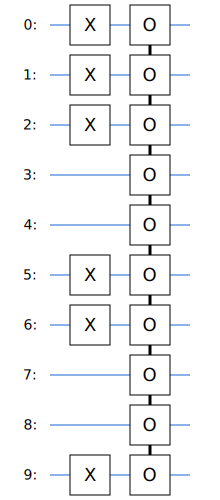



Amplitude 921 has value (-1+0j)


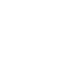

In [ ]:
#@title
# Show the basic behaviour of the Oracle

num_values = 5
hidden_values = []
assign_hidden_values(hidden_values)
print('\nHidden values:', hidden_values)

while True:
    choice = input('Enter number to test: ')
    if not choice.isdigit():
        print(choice, ' is not an integer')
        continue
    choice = int(choice)
    if choice < 0:
        print(choice, ' negative')
        continue
    if choice >= input_values:
        print(f'choice {choice} not less than input values {input_values}')
        continue
    break

# Create the global variables used
input_qubits = 10
extra_qubits = 0

qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

circuit = cirq.Circuit()

gates = []
for bit in range(10):
    if choice & (1<<(9-bit)):
        gates.append(cirq.X(qubits[bit]))
circuit.append(gates)

oracle = OracleGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
circuit.append(oracle, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
# Nothing really to measure since it just negates amplitudes

print('\nOracle:\n')
svgprint(circuit)
print('\n')

# Simulate the circuit.
simulator  = cirq.Simulator()
result     = simulator.simulate(circuit)

count = 0
for i in range(len(result.final_state)):
    amplitude = result.final_state[i]
    if amplitude != 0:
        print(f'Amplitude {i} has value {amplitude}')
        if amplitude < 0:
            count += 1

if count == 0:
    print("No amplitudes have negative values")
    no_answer()
else:
    yes_answer()


### Grover diffusion operator

The Grover diffusion operator reflects all amplitudes about the mean of those same amplitudes. If the vector *v* contains this mean amplitude value in every element, then the Householder transformation referred to as the Grover diffusion operator is G = (2|v&gt;&lt;v| - I).  Since &lt;v|v&gt; = 1 G|v> = |v> and so |v> is an eigen vector of G.

To construct G we construct the simpler Householder transformation G0 = (2|0&gt;&lt;0| - I). Note that (2|0&gt;&lt;0| - I) is simply the identity matrix I with every diagonal except for the first element negated. Thus it negates every value except |0>. It is obviously unitary.  Central to constructing G0 is a quantum gate that negates just |0&gt;. After this all amplitudes are negated using ZXZX on any one line to derive G0.  G0 is then pre and post multiplied by Hadamards on every input line to construct G.  Clarity as to how this produces G can be obtained by playing with small examples.

Initially in this presentation we implement G directly as a unitary matrix. Later in this presentation we show how to construct it from basic quantum gates.  If G is an n x n matrix its diagonal entries must each have the value $(2/n)-1$ and all it's off diagonal entries must have the value $2/n$.



#### The mathematics

To explain this transform let $A_{n}$ be the matrix operator : $A_{n}×u_{n}=v_{n}$ where every element of $v_{n}$ is the average of the elements in $u_{n}$. Then $A_{n}$ is the non-unitary matrix in which every element has the value $1/n$. This is because the average of $u_{n}$ is simply the sum of values in $u_{n}$ divided by the number of values $n$ in $u_{n}$.  

To reflect $u_{n}$ about $v_{n}$ compute $u_{n} - v_{n}$ which gives the separation of each element in $u_{n}$ from the mean $v_{n}$, and then compute $v_{n} – (u_{n} - v_{n})$ which reflects the elements of $u_{n}$ about $v_{n}$. Equivalently, compute $A_{n} u_{n}  – (u_{n} - A_{n} u_{n}) = (2 A_{n} – I_{n}) u_{n} = D_{n} u_{n}$. Thus $D_{i,j} =(2/n)-1$ when $i=j$ and $2/n$ otherwise. 

Since $((2/n)-1)^{2}+(n-1)(2/n)^{2}=1$ and $2((2/n)-1)(2/n)+(n-2)(2/n)^{2}=0$  rather remarkably $D_{n}$ is unitary.  Thus while a quantum computer cannot use the non-unitary $A_{n}$ to average all amplitudes, it can rotate all amplitudes about this unknown average value.

In [ ]:
check_householder_unitary()

 (2/n)-1= -0.998046875 2/n= 0.001953125

Householder unitary:
max_diag= -0.998046875  min_diag= -0.998046875  max_off= 0.001953125  min_off= 0.001953125

Householder unitary squared:
max_diag= 1.0  min_diag= 1.0  max_off= 0.0  min_off= 0.0


## Run Grover's algorithm

![Grover's Algorithm](https://cs.uwaterloo.ca/~ijdavis/qic895/grover.jpg)


Adding additional ancillary qubits is problematic.  Our algorithm will be tensored with the 2x2 identity matrix $I$ across each of the $a$ ancillary lines, and so $2^{a}$ copies of itself will be executed in parallel, one for each possible binary value associated with the tensored ancillary qubits.  

If the ancillary qubits are not in a superposition of values then the fixed ancillary value will neither impact, nor be changed by either the Oracle or Grover's diffusion operator, and these extra anxiliary qubits will not conflict with Grover's algorithm.  This is because only the amplitudes for this one fixed value will be non-zero.  

But if multiple values associated with these ancillary lines have non-zero amplitudes, distinct applications of Grover's algorithm will be operating in parallel on each of these distinct values. Consequently each application will be operating on regions of the state vector which has both zero and non-zero amplitudes. This is counter to the required setup for Grover's algorithm which expects all lines to be in an equi-superposition.

If we seek to perform Grover's diffusion operator after applying Hadamards to auxiliary lines containing |1> so as to include the ancilliary lines in some larger single application of the Grover operator, we introduce positive and negative amplitudes, again counter to the requirement that Grover's algorithm expects all amplitudes to initially have the same sign. 

Finally, if Grover's algorithm does not manipulate all amplitudes for common original patterns in precisely the same way, we will be unable to recover these patterns recorded in these auxillary qubits with certainty, by performing a second Hadamard operation on them.  This is because such qubits will no longer be in the balanced amplitude Hadamard state necessary to do so.


Hidden values: [601]

Optimal Rotations/Iterations = (π/4)√(2^inputs) = (π/4)√(2^10) = 25

Grover Circuit:


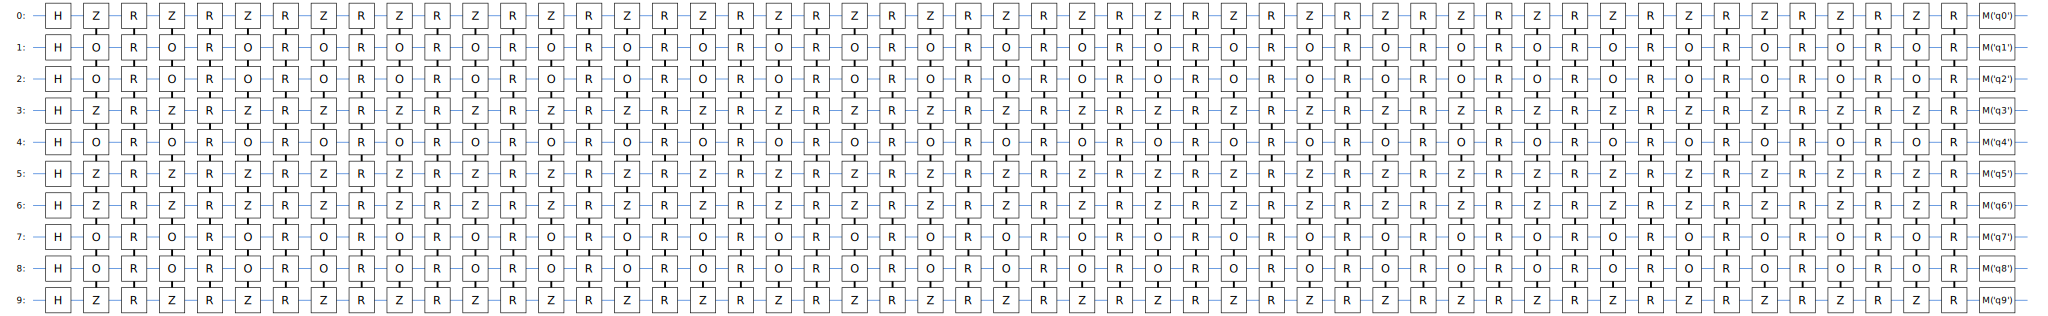


After execution:

Amplitudes: max= (0.999951+0j)  min= 0j
601 0x259 : Amplitude (0.9999510049819946+0j) Probability (99.99020099639893+0j)%

Measured: 601

Hidden values: [601]


In [ ]:
#@title
num_values = 1
hidden_values = []
assign_hidden_values(hidden_values)
print(f'\nHidden values: {hidden_values}')

input_qubits = 10
extra_qubits = 0

# Create the global variables used
qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

circuit = cirq.Circuit()

gates   = []
# Perform H on all input lines
set_same_amplitudes(gates)

# Compute the optimal number of rotations for a single marked value
rotations   = int((math.pi/4) * math.sqrt(input_values/num_values))
print(f'\nOptimal Rotations/Iterations = (π/4)√(2^inputs) = (π/4)√(2^10) = {color.BOLD}{color.BLUE}{rotations}{color.END}')

# Perform the optimal number of rotations
for rotation in range(rotations):
    gate = OracleGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)

# Add all gates to circuit
circuit.append(gates)

# Measure inputs at end of execution
for qubit in range(len(qubits)):
     circuit.append([cirq.measure(qubits[qubit], key=f'q{qubit}')])

print('\nGrover Circuit:')
svgprint(circuit)

# Simulate the circuit.
simulator  = cirq.Simulator()
result     = simulator.simulate(circuit)
print("\nAfter execution:")
describe_amplitudes(result.final_state)
measurements = result.measurements
measured     = 0
for qubit in range(len(qubits)):
    measured <<= 1
    # Have to wonder if there is an easier way to do this
    measured  |= measurements[f'q{qubit}'][0]
print(f'\n{color.BOLD}{color.BLUE}Measured: {measured}{color.END}')
print(f'\nHidden values: {hidden_values}')


## Trace circuit behaviour

By simulating Grover's algorithm we can directly observe how it amplifies amplitudes.


Hidden values: [148]

Optimal Rotations/Iterations: 25

24: amplitude(148)=0.9991406798362732 amplitude(0)=0.0312499962747097
25: amplitude(148)=0.9996308088302612 amplitude(0)=0.0312499962747097
26: amplitude(148)=0.9962173700332642 amplitude(0)=0.0312499962747097




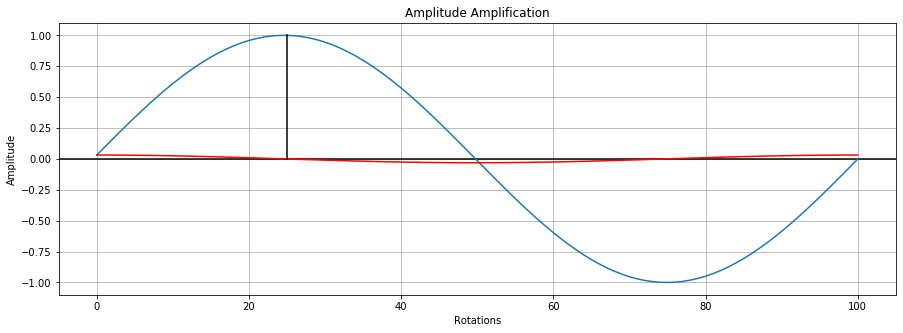


This is almost identical to a sine wave with wave length 25*4=100



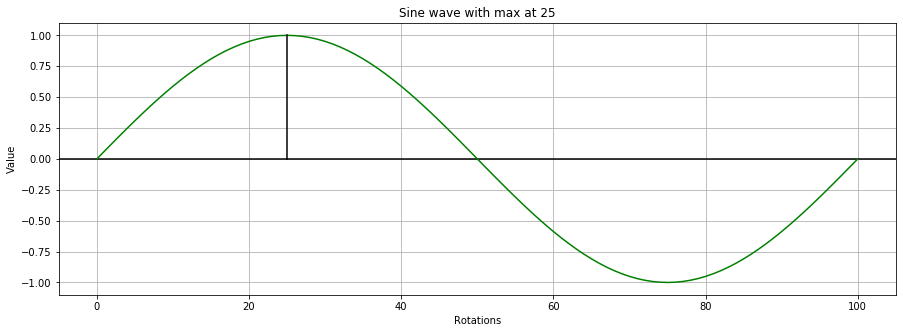

In [ ]:
#@title
# Reveal the iterative improvement in amplitudes

num_values = 1
hidden_values = []
assign_hidden_values(hidden_values)
print(f'\nHidden values: {color.BLUE}{hidden_values}{color.END}')

input_qubits = 10
extra_qubits = 0

# Create the global variables used
qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

gates       = []
set_same_amplitudes(gates)

for rotation in range(100):
    gate = OracleGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)

circuit = cirq.Circuit()
circuit.append(gates)

marked, unmarked = get_marked_unmarked()

marked_amplitude   = []
unmarked_amplitude = []

rotations   = int((math.pi/4) * math.sqrt(input_values/num_values))
print(f'\nOptimal Rotations/Iterations: {color.BLUE}{rotations}{color.END}\n')

simulator   = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    if i & 1:
        # Ignore the oracle step
        continue
    if marked != -1:
        marked_amplitude.append(step.state_vector()[marked].real)
    if unmarked != -1:
        unmarked_amplitude.append(step.state_vector()[unmarked].real)

for iteration in range(24,27):
    print(f'{iteration}: amplitude({marked})={marked_amplitude[iteration]} amplitude({unmarked})={unmarked_amplitude[unmarked]}')
print('\n')

plot(marked_amplitude, unmarked_amplitude, 25)
print(f'\nThis is almost identical to a sine wave with wave length {rotations}*4={rotations*4}\n')
plot_sine(100, 25)

## What about with 10 hidden values

The sine wave rotates much faster.


Hidden values: [1016, 222, 642, 463, 704, 614, 334, 358, 83, 990]

Optimal Rotations/Iterations = (π/4)√((2^inputs)/marked) = (π/4)√((2^10)/10) = 7

6: amplitude(1016)=0.30355820059776306 amplitude(0)=0.0312499962747097
7: amplitude(1016)=0.31505724787712097 amplitude(0)=0.0312499962747097
8: amplitude(1016)=0.31424933671951294 amplitude(0)=0.0312499962747097




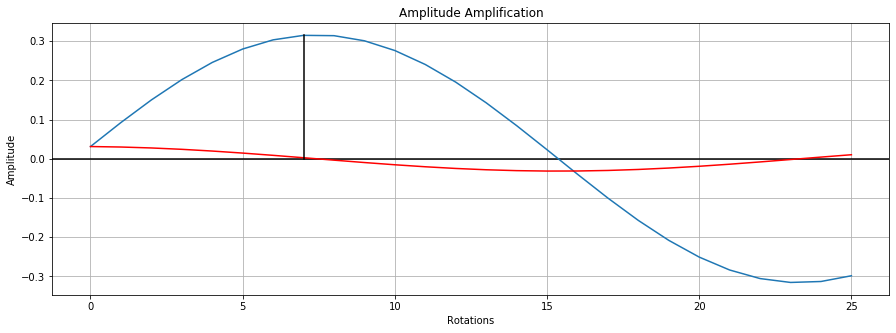

In [ ]:
#@title
# Reveal the iterative improvement in amplitudes

num_values = 10
hidden_values = []
assign_hidden_values(hidden_values)
print('\nHidden values:', hidden_values)

input_qubits = 10
extra_qubits = 0

# Create the global variables used
qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

gates       = []
set_same_amplitudes(gates)

rotations   = int((math.pi/4) * math.sqrt(input_values/num_values))
print(f'\nOptimal Rotations/Iterations = (π/4)√((2^inputs)/marked) = (π/4)√((2^10)/10) = {color.BOLD}{color.BLUE}{rotations}{color.END}\n')

for rotation in range(25):
    gate = OracleGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)

circuit = cirq.Circuit()
circuit.append(gates)

marked, unmarked = get_marked_unmarked()

marked_amplitude   = []
unmarked_amplitude = []

simulator   = cirq.Simulator()

for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    if i & 1:
        # Ignore the oracle step
        continue
    if marked != -1:
        marked_amplitude.append(step.state_vector()[marked].real)
    if unmarked != -1:
        unmarked_amplitude.append(step.state_vector()[unmarked].real)

for iteration in range(6,9):
    print(f'{iteration}: amplitude({marked})={marked_amplitude[iteration]} amplitude({unmarked})={unmarked_amplitude[unmarked]}')
print('\n')

plot(marked_amplitude, unmarked_amplitude, rotations)

## What about 700 values out of 1024

Grover's algorithm as earlier described fails.  This is because the suggested number of rotations performed will be 0.

The challenge now is to perform a number of iterations which minimizes the amplitudes of those states we don't want to be told about. Indeed that is perhaps in general a better description of our algorithms objective since zero is a known value while our maximal amplitude varies, and most machine learning algorithms are understood in terms of reducing an absolute cost function to near zero.  These unmarked amplitudes do cross the x-axis as shown, each time their angle increases through a multiple of π (since sin(n.π) = 0) so this is possible.

Of course if at least half the values are marked, the challenge of finding a marked value with high probability can be trivially solved by classical means. Just guess until a satisfying value is found. After $g$ guesses the probability of success is $1 - ((N-m)/N)^{g} ≥ 1- 0.5^{g}$.

Suggested Rotations = (π/4)√((2^inputs)/marked) = (π/4)√(1024/700) = 0
Best rotations= 10 

 9: amplitude(109)=-0.013143133372068405 amplitude(0)=0.0312499962747097
10: amplitude(109)=0.037788473069667816 amplitude(0)=0.0312499962747097
11: amplitude(109)=-0.014608245342969894 amplitude(0)=0.0312499962747097




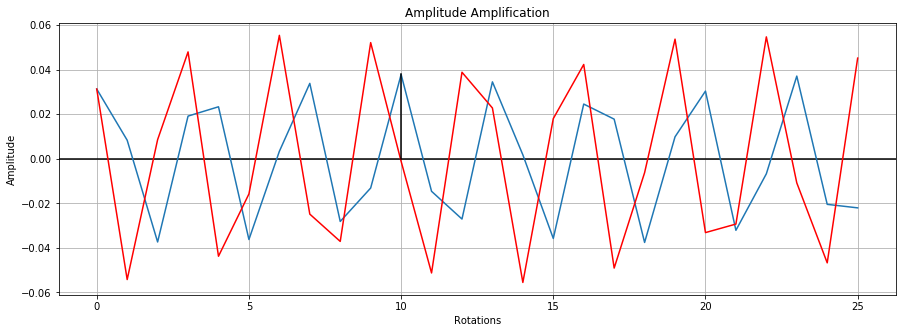

In [ ]:
#@title
# Reveal the iterative improvement in amplitudes

num_values = 700
hidden_values = []
assign_hidden_values(hidden_values)

input_qubits = 10
extra_qubits = 0

# Create the global variables used
qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

gates       = []
set_same_amplitudes(gates)

for rotation in range(25):
    gate = OracleGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)

circuit = cirq.Circuit()
circuit.append(gates)

marked, unmarked   = get_marked_unmarked()
marked_amplitude   = []
unmarked_amplitude = []

simulator   = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    if i & 1:
        # Ignore the oracle step
        continue
    marked_amplitude.append(step.state_vector()[marked].real)
    unmarked_amplitude.append(step.state_vector()[unmarked].real)

rotations   = int((math.pi/4) * math.sqrt(input_values/num_values))
print(f'{color.RED}Suggested Rotations = (π/4)√((2^inputs)/marked) = (π/4)√(1024/700) = {rotations}{color.END}')
rotations   = 10
print('Best rotations=', rotations,'\n')

for iteration in range(9,12):
    print(f'{iteration:>2d}: amplitude({marked})={marked_amplitude[iteration]} amplitude({unmarked})={unmarked_amplitude[unmarked]}')
print('\n')

plot(marked_amplitude, unmarked_amplitude, rotations)

### A better strategy

When the marked values exceeds half the input, negate the Oracle (so that it is now marking earlier unmarked values) and double the optimal number of rotations. This will find the point where the originally unmarked values have amplitude close to zero (since their angles will be close to n.π and sin(n.π) = 0) and thus the point where the amplitudes we want to amplify have near maximal absolute amplitude.


Optimal Rotations/Iterations = (π/2)√((2^inputs)/(2^inputs - marked) = (π/2)√(1024/324) = 2

 1: amplitude(227)=-0.008300777524709702 amplitude(4)=-0.04374257102608681
 2: amplitude(227)=-0.03734588623046875 amplitude(4)=-0.04374257102608681
 3: amplitude(227)=-0.01912510395050049 amplitude(4)=-0.04374257102608681




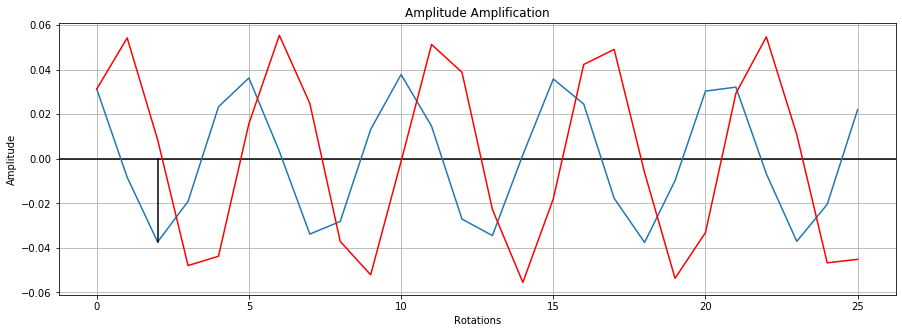

In [ ]:
#@title
# Reveal the iterative improvement in amplitudes

num_values = 700
hidden_values = []
assign_hidden_values(hidden_values)

input_qubits = 10
extra_qubits = 0

# Create the global variables used
qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

gates       = []
set_same_amplitudes(gates)

rotations   = int((math.pi/2) * math.sqrt(input_values/(input_values - num_values)))
print(f'\nOptimal Rotations/Iterations = (π/2)√((2^inputs)/(2^inputs - marked) = (π/2)√(1024/324) = {color.BOLD}{color.BLUE}{rotations}{color.END}\n')

for rotation in range(25):
    oracle = OracleGate()
    oracle.negate()
    gate   = oracle.on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)
    
circuit = cirq.Circuit()
circuit.append(gates)

marked, unmarked   = get_marked_unmarked()
marked_amplitude   = []
unmarked_amplitude = []

simulator   = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    if i & 1:
        # Ignore the oracle step
        continue
    marked_amplitude.append(step.state_vector()[marked].real)
    unmarked_amplitude.append(step.state_vector()[unmarked].real)

for iteration in range(1,4):
    print(f'{iteration:>2d}: amplitude({marked})={marked_amplitude[iteration]} amplitude({unmarked})={unmarked_amplitude[unmarked]}')
print('\n')

plot(marked_amplitude, unmarked_amplitude, rotations)

## Unknown number of marked values

If at least half the total number of distinct values are marked, simply guess at the marked values using any classical approach and then test to see if the guess represents a satisfying solution. This will (with high probability) quickly discover a marked value. 

So suppose that the number of marked values $m$ is less than half the total number of possibly marked values.  Then Grover's algorithm can be repeatedly executed using distinct guesses for the value of $m$.  Each such guess will be effectively sampling a value for the number of rotations to perform (shown below), from the actual distribution of optimal rotations. This will (with high probability) quickly discover a marked value.

Repeating the above two strategies will quickly discover a satisfying value, irrespective of the number of such satisfying solutions. If after some number of such attempts we fail to find any satisfying solution we can conclude with high probability that there are none.


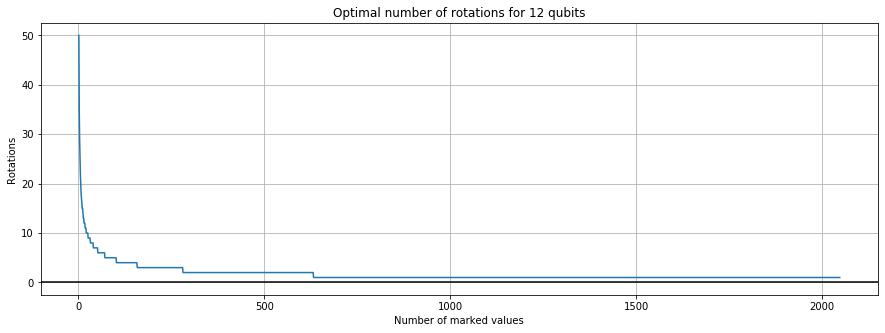

 1 qubits :     2 values : 0.5
 2 qubits :     4 values : 1.0
 3 qubits :     8 values : 0.7615313202626965
 4 qubits :    16 values : 0.7461404594161337
 5 qubits :    32 values : 0.7147846252883551
 6 qubits :    64 values : 0.6828785855511731
 7 qubits :   128 values : 0.6630351323893229
 8 qubits :   256 values : 0.6499357155251566
 9 qubits :   512 values : 0.6418460550111353
10 qubits : 1,024 values : 0.6358521136636345
11 qubits : 2,048 values : 0.6317496128098248
12 qubits : 4,096 values : 0.6288956160541079


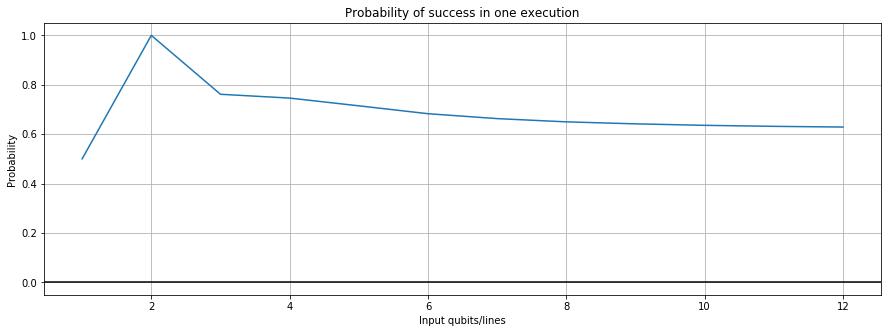

In [ ]:
#@title
def get_all_rotations(input_qubits):

    all_rotations = [numpy.nan]
    # For every possible guess as to this number
    input_values = 2**input_qubits
    half_values  = input_values >> 1
    for marked in range(1, half_values):
        # How many rotations will our guess indicate are needed
        rotations   = int((math.pi/4.0) * math.sqrt(input_values/marked))
        # print(f'Marked {guess} rotations {rotations}')
        all_rotations.append(rotations)
    return all_rotations

def plot_rotations(rotations, input_qubits):
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.axhline(y=0,color='k')
    matplotlib.pyplot.plot(rotations)
    matplotlib.pyplot.title(f'Optimal number of rotations for {input_qubits} qubits')
    matplotlib.pyplot.ylabel('Rotations')
    matplotlib.pyplot.xlabel('Number of marked values')
    matplotlib.pyplot.grid(True, which='Both')
    matplotlib.pyplot.show()

def get_success_probability(input_qubits):

    if input_qubits == 1:
        # Just 2 values so assume 1 marked
        return 0.5  

    input_values = 2**input_qubits
    half_values  = input_values >> 1

    initial_angle = math.asin(1/math.sqrt(input_values))

    count = 0.0
    sum   = 0.0
    
    for guess in range(1, half_values):
        # How many rotations will our guess indicate are needed
        rotations   = int((math.pi/4.0) * math.sqrt(input_values/guess))
        # For every possible number of marked values < half input values
        for marked in range(1, half_values):
            # How much will marked amplitudes be rotated at each step
            angle       = 2 * math.asin(1/math.sqrt(input_values/marked))
            # What will the angle of our marked amplitudes become
            final_angle = initial_angle + angle*rotations
            #print(f'final angle {final_angle/math.pi} Pi')
            amplitude   = math.sin(final_angle)
            sum        += amplitude**2
            count      += 1.0

    return sum/count

def plot_probabilities(probabilities):
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.axhline(y=0,color='k')
    matplotlib.pyplot.plot(probabilities)
    matplotlib.pyplot.title('Probability of success in one execution')
    matplotlib.pyplot.ylabel('Probability')
    matplotlib.pyplot.xlabel('Input qubits/lines')
    matplotlib.pyplot.grid(True, which='Both')
    matplotlib.pyplot.show()

# What is the probability of seeing a marked value by guessing the value of m

#all_rotations = get_all_rotations(10)
#plot_rotations(all_rotations, 10)
all_rotations = get_all_rotations(12)
plot_rotations(all_rotations, 12)

all_probabilities = [numpy.nan]
for input_qubits in range(1,13):
    probability = get_success_probability(input_qubits)
    print(f'{color.BLUE}{input_qubits:>2d}{color.END} qubits : {2**input_qubits:>5,} values : {color.BLUE}{probability}{color.END}')
    all_probabilities.append(probability)
plot_probabilities(all_probabilities)


### Quantum Approximate Counting

The challenge of actually determining the number of marked values $m$ is called Quantum Approximate Counting which seeks to determine the cardinality of an unknown set. This challenges can be solved by using Grover's Iterations followed by a final Quantum Phase Estimation which employs the Quantum Fourier Transform, to determine the phase of the sine wave shown earlier, from which can be recovered an approximation of the number of marked values.

Interestingly Quantum Approximate Counting can also be solved efficiently by considering the frequency of the sine wave (how fast it turns) using just Grover Iterations &lsqb;Aaronson]. The basic idea is to compare the frequency of our unknown sine wave to the frequency of a known sine wave (both generated by Grover Iterations) to determine when their values are orthogonal.  This is much like determining the frequency of an inaccurate clock, by comparing it to a trusted clock.

Both approaches are *O(c . √(N/m)/ε)* where c is a large integer ~1000 and ε promises that our approximate answer will be in the range s ≤ m ≤ ε×s.  It appears much harder to accurately determine $m$ than to recover the value of one such marked $m$.

# Decomposing the Householder Unitary

The real challenge of implementing a Householder Unitary that can be applied to $n$ qubits, is the challenge of negating the single amplitude of |0> (after applying Hadamards) when there are a total of $n$ input lines and thus $2^{n}$ amplitudes in equi-superposition.  With 10 input lines this requires that we implement a *C9Z* control operation on *9* input lines that negates a final 10th input line when that line is |1>.

It feels unjust that it is this hard to negate the very amplitude which was initially the only non-zero amplitude in our entire quantum state.

## Functions used

In [ ]:
#@title
# To build the unitary decomposition for a n-times controlled gate

# Create a suitable gray code of length 2^n for the n  (qubits)
# https://www.geeksforgeeks.org/generate-n-bit-gray-codes
#
# Our constructed gray code
# 1. Begins with 0 [ignored] and then 2^(n-1)
#    -- Our first action is to test the high order qubit
# 2. It is a gray code. Successive values differ by just one bit
#    -- This means we require no X operations anywhere
# 3. The array contains in some order the 2^n distinct values 0-(2^n-1)
#    -- This means we will consider every possible xor combination
# 4. Each xor described by the value ordering can be created using one CNOT
#    -- This means the solution is optimal
# 5. The CNOTS leave the final state of the line inputs unchanged
#    -- This is an obvious but subtle requirement (at first missed)
#    -- It is a special property of our gray code (not honoured by all)
# 6. CNOTS always use as source higher order bits than target
#    -- Why generate an ugly circuit when it could be oh so pretty
# 7. Prefer solutions which target high order qubits earlier
#    -- This creates an easy to understand logical circuit flow
#    -- It also improves the appearance of the circuit diagram

# Earlier solution (as example):
# gray5 = [0x10,0x18,0x8,0xc,0x1c,0x1e,0x16,0x14,0x4,0x6,0xe,0xf,0x1f,0x1b,0xb,0xa,0x1a,0x12,0x2,0x3,0x13,0x17,0x7,0x5,0x15,0x1d,0xd,0x9,0x19,0x11,0x1]   

# An array of increasing length gray codes
# These are dynamically created as needed
grays = []

# Create the next gray code from the last
# Our custom construction (that seems to work)
def extend_gray(input, output):
    high_bit = len(input)
    for i in range(high_bit):
        val = input[i]
        if i & 1:
            output.append(val | high_bit)
            output.append(val)
        else:
            output.append(val)
            output.append(val | high_bit)

# Get the requested gray code of length 2^n
def get_gray(n):
    global grays

    while len(grays) < n:
        grays.append([])

    new_gray = []
    for i in range(n):
        new_gray = grays[i]
        if new_gray == []:
            if i == 0:
                new_gray.append(0)
                new_gray.append(1)
            else:
                extend_gray(grays[i-1], new_gray)
    return new_gray

# Test that any constructed gray code is indeed valid
# Pretty redundant given that it obviously will be
def test_gray(n):
    errors   = 0
    input    = get_gray(n)
    values   = len(input)

    bits     = 0
    value1   = values - 1
    while value1 != 0:
        value1 = value1 >> 1
        bits  += 1 
    
    for index in range(1,values):
        value0 = input[index-1]
        value1 = input[index]
        diff   = 0
        for bit in range(bits):
            if (value0 & (1<<bit)) != (value1 & (1<<bit)):
                diff += 1
        if diff != 1:
            print("index:", index, bin(value0), bin(value1), " differs by ", diff)
            errors += 1
        value0 = value1

    for index in range(values):
        if not index in input:
            printf("Missing ", index)
            errors += 1

    if errors == 0:
        print(f'Gray code with 2^{n} values is valid\n')
        # Show the gray code used
        print(''.join(' 0x'+format(x, '02x') for x in input))
    else:
        print(errors, ' errors\n')
    return

# ---- Generate a CnX/CnZ n-controlled gate

# Get the gates to implement a controlled n-times gate of type
def get_Cn_gates(n, type):
    gates  = []
    gray   = get_gray(n)
    index  = 1
    value  = gray[index]
    target = 0
    qis    = numpy.zeros(n,dtype=int)
    for bit in range(n):
      qis[bit] = (1<<(n-1-bit))

    cmds   = ''
    exp    = str(1.0/(1<<(n-1)))
    prefix = ' '
    while True:
        parity  = 0
        binary  = ' # 0b'
        xor     = '' 
        for bit in range(n):
            if value & (1<<(n-1-bit)):
                binary += '1'
                if parity != 0:
                    xor += '⊕'
                xor    += 'q'+str(bit)
                parity += 1
            else:
                binary += '0'

        if parity & 1:
            sign = ' '
        else:
            sign = '-'
        
        stmt = prefix+'cirq.C'+type+'PowGate(exponent='+sign+exp+').on(q'+str(target)+',qx)'+binary+' q'+str(target)+'='+xor+'\n'
        prefix = ','
        cmds  += stmt
        index += 1
        if index == len(gray):
            break

        # Which bit changed in the gray code
        value = gray[index]
                
        # If some target has this value we can use it
        for target in range(n):
            if qis[target] == value:
                continue
        
        # We want to set some target so it has value using a CNOT from an earlier qubit
        seen = 0
        for target in range(1,n):
            for source in range(target):
                if (qis[source] ^ qis[target]) == value:
                    stmt  = prefix+'cirq.CX(q'+str(source)+',q'+str(target)+')\n'
                    cmds += stmt
                    qis[target] = value
                    seen = 1
                    break
            if seen == 1:
                break
                     
        if seen == 0:
            print("Can't construct ", format(value, '#b'))
            for source in range(n):
                print(f'q{source}=', format(qis[source],'#b'))
            return []
    
    return '[\n'+cmds+']'

# --- Create the C5X, C5Z and C9Z gates used

#@title
# Create a CCCCCX and CCCCCZ operation since cirq seems to lack it

import abc # Abstract Base Class
from typing import Optional, Tuple

class FourQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 4

class C3XGate(cirq.ops.eigen_gate.EigenGate,
           FourQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A triple-controlled-NOT
    #
    # The matrix is an 16x16 identity except the bottom right 2x2 area is X
    
    def _eigen_components(self):
        lth = (1<<self._num_qubits_()) - 2
        a1  = numpy.ones(lth,dtype=int)
        a0 = numpy.zeros(lth,dtype=int)
        return [
            (0, linalg.block_diag(numpy.diag(a1),
                                  numpy.array([[0.5, 0.5], [0.5, 0.5]]))),
            (1, linalg.block_diag(numpy.diag(a0),
                                  numpy.array([[0.5, -0.5], [-0.5, 0.5]]))),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.X
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
  
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    def _decompose_(self, qubits):
        q1, q2, q3, qx = qubits
        return [
            cirq.CNotPowGate(exponent= 0.25).on(q0,qx) # 0b100 q0=q0
           ,cirq.CX(q0,q1)
           ,cirq.CNotPowGate(exponent=-0.25).on(q1,qx) # 0b110 q1=q0⊕q1
           ,cirq.CX(q0,q1)
           ,cirq.CNotPowGate(exponent= 0.25).on(q1,qx) # 0b010 q1=q1
           ,cirq.CX(q1,q2)
           ,cirq.CNotPowGate(exponent=-0.25).on(q2,qx) # 0b011 q2=q1⊕q2
           ,cirq.CX(q0,q2)
           ,cirq.CNotPowGate(exponent= 0.25).on(q2,qx) # 0b111 q2=q0⊕q1⊕q2
           ,cirq.CX(q1,q2)
           ,cirq.CNotPowGate(exponent=-0.25).on(q2,qx) # 0b101 q2=q0⊕q2
           ,cirq.CX(q0,q2)
           ,cirq.CNotPowGate(exponent= 0.25).on(q2,qx) # 0b001 q2=q2
           ]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', 'X'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C3XGate'
 
    def __str__(self) -> str:
        return 'C3XGate'

class C3ZGate(cirq.ops.eigen_gate.EigenGate,
           FourQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 3-controlled-Z
    #
    # The matrix is an 16x16 identity except the bottom right 2x2 area is Z
    
    def _eigen_components(self):
        dim = 1 << self._num_qubits_()
        a1 = numpy.ones(dim,dtype=int)
        a1[dim-1] = 0
        a0 = numpy.zeros(dim,dtype=int)
        a0[dim-1] = 1
        return [
            (0, numpy.diag(a1)),
            (1, numpy.diag(a0)),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.Z
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)
    
    def _decompose_(self, qubits):
        q0, q1, q2, qx = qubits

        ops   = get_Cn_gates(self._num_qubits_()-1, 'Z')
        return [eval(ops)]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', 'Z'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C3ZGate'
 
    def __str__(self) -> str:
        return 'C3ZGate'

class FiveQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 5

class C4XGate(cirq.ops.eigen_gate.EigenGate,
           FiveQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 4-controlled-NOT
    #
    # The matrix is an 64x64 identity except the bottom right 2x2 area is X
    
    def _eigen_components(self):
        lth = (1<<self._num_qubits_()) - 2
        a1 = numpy.ones(lth,dtype=int)
        a0 = numpy.zeros(lth,dtype=int)
        return [
            (0, linalg.block_diag(np.diag(a1),
                                  np.array([[0.5, 0.5], [0.5, 0.5]]))),
            (1, linalg.block_diag(np.diag(a0),
                                  np.array([[0.5, -0.5], [-0.5, 0.5]]))),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    # This function is used to proceed efficiently when simulating
    # It exploits knowledge about exactly when the X will be applied
    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:
       
        ret = cirq.ops.pauli_gates.X
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    # This function is used when we really need the quantum gates to proceed
    # That occurs when we are genuinely running on a quantum computer
    def _decompose_(self, qubits):
        q0, q1, q2, q3, qx = qubits

        ops   = get_Cn_gates(4, 'Not')
        return [eval(ops)]

    # This function is used to pretty print this gate in a circuit diagram
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', 'X'),
            exponent=1)

    # This function is used to generate assembler for the circuit
    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    # This function is supposed to return something that evals to this gate
    def __repr__(self) -> str:
        return 'C4XGate'
 
    def __str__(self) -> str:
        return 'C4XGate'

class C4ZGate(cirq.ops.eigen_gate.EigenGate,
           FiveQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 4-controlled-Z
    #
    # The matrix is an 32x32 identity except the bottom right 2x2 area is Z
    
    def _eigen_components(self):
        dim = 1 << self._num_qubits_()
        a1 = numpy.ones(dim,dtype=int)
        a1[dim-1] = 0
        a0 = numpy.zeros(dim,dtype=int)
        a0[dim-1] = 1
        return [
            (0, numpy.diag(a1)),
            (1, numpy.diag(a0)),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.Z
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)
    
    def _decompose_(self, qubits):
        q0, q1, q2, q3, qx = qubits

        ops   = get_Cn_gates(4, 'Z')
        return [eval(ops)]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', 'Z'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C4ZGate'
 
    def __str__(self) -> str:
        return 'C4ZGate'

class SixQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 6

class C5XGate(cirq.ops.eigen_gate.EigenGate,
           SixQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 5-controlled-NOT
    #
    # The matrix is an 64x64 identity except the bottom right 2x2 area is X
    
    def _eigen_components(self):
        lth = (1<<self._num_qubits_()) - 2
        a1 = numpy.ones(lth,dtype=int)
        a0 = numpy.zeros(lth,dtype=int)
        return [
            (0, linalg.block_diag(np.diag(a1),
                                  np.array([[0.5, 0.5], [0.5, 0.5]]))),
            (1, linalg.block_diag(np.diag(a0),
                                  np.array([[0.5, -0.5], [-0.5, 0.5]]))),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < 5

    # This function is used to proceed efficiently when simulating
    # It exploits knowledge about exactly when the X will be applied
    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.X
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    # This function is used when we really need the quantum gates to proceed
    # That occurs when we are genuinely running on a quantum computer
    def _decompose_(self, qubits):
        q0, q1, q2, q3, q4, qx = qubits

        ops   = get_Cn_gates(5, 'Not')
        return [eval(ops)]

    # This function is used to pretty print this gate in a circuit diagram
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', '@', 'X'),
            exponent=1)

    # This function is used to generate assembler for the circuit
    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    # This function is supposed to return something that evals to this gate
    def __repr__(self) -> str:
        return 'C5XGate'
 
    def __str__(self) -> str:
        return 'C5XGate'

class C5ZGate(cirq.ops.eigen_gate.EigenGate,
           SixQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 5-controlled-Z
    #
    # The matrix is an 64x64 identity except the bottom right 2x2 area is Z
    
    def _eigen_components(self):
        dim = 1 << self._num_qubits_()
        a1 = numpy.ones(dim,dtype=int)
        a1[dim-1] = 0
        a0 = numpy.zeros(dim,dtype=int)
        a0[dim-1] = 1
        return [
            (0, numpy.diag(a1)),
            (1, numpy.diag(a0)),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.Z
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)
    
    def _decompose_(self, qubits):
        q0, q1, q2, q3, q4, qx = qubits

        ops   = get_Cn_gates(5, 'Z')
        return [eval(ops)]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', '@', 'Z'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C5ZGate'
 
    def __str__(self) -> str:
        return 'C5ZGate'

class SevenQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 7

class C6XGate(cirq.ops.eigen_gate.EigenGate,
           SevenQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A 6-controlled-NOT
   
    def _eigen_components(self):
        lth = (1<<self._num_qubits_()) - 2
        a1 = numpy.ones(lth,dtype=int)
        a0 = numpy.zeros(lth,dtype=int)
        return [
            (0, linalg.block_diag(np.diag(a1),
                                  np.array([[0.5, 0.5], [0.5, 0.5]]))),
            (1, linalg.block_diag(np.diag(a0),
                                  np.array([[0.5, -0.5], [-0.5, 0.5]]))),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    # This function is used to proceed efficiently when simulating
    # It exploits knowledge about exactly when the X will be applied
    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:
       
        ret = cirq.ops.pauli_gates.X
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    # This function is used when we really need the quantum gates to proceed
    # That occurs when we are genuinely running on a quantum computer
    def _decompose_(self, qubits):
        q0, q1, q2, q3, q4, q5, qx = qubits

        ops   = get_Cn_gates(6, 'Not')
        return [eval(ops)]

    # This function is used to pretty print this gate in a circuit diagram
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', '@', '@', 'X'),
            exponent=1)

    # This function is used to generate assembler for the circuit
    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    # This function is supposed to return something that evals to this gate
    def __repr__(self) -> str:
        return 'C6XGate'
 
    def __str__(self) -> str:
        return 'C6XGate'

class C6ZGate(cirq.ops.eigen_gate.EigenGate,
           SevenQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    
    def _eigen_components(self):
        dim = 1 << self._num_qubits_()
        a1 = numpy.ones(dim,dtype=int)
        a1[dim-1] = 0
        a0 = numpy.zeros(dim,dtype=int)
        a0[dim-1] = 1
        return [
            (0, numpy.diag(a1)),
            (1, numpy.diag(a0)),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < (self._num_qubits_() - 1)

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.Z
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)
    
    def _decompose_(self, qubits):
        q0, q1, q2, q3, q4, q5, qx = qubits

        ops   = get_Cn_gates(6, 'Z')
        return [eval(ops)]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', '@', '@', '@', 'Z'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C6ZGate'
 
    def __str__(self) -> str:
        return 'C6ZGate'

class TenQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 10

class C9ZGate(cirq.ops.eigen_gate.EigenGate,
           TenQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    
    def _eigen_components(self):
        dim = 1 << self._num_qubits_()
        a1 = numpy.ones(dim,dtype=int)
        a1[dim-1] = 0
        a0 = numpy.zeros(dim,dtype=int)
        a0[dim-1] = 1
        return [
            (0, numpy.diag(a1)),
            (1, numpy.diag(a0)),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < 9

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:

        ret = cirq.ops.pauli_gates.Z
        lth = self._num_qubits_() - 1
        for i in range(lth):
            ret = cirq.ops.controlled_gate.ControlledGate(ret)
        return cirq.protocols.apply_unitary(
            ret,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)
       
    def _decompose_(self, qubits):
        q0, q1, q2, q3, q4, q5, q6, q7, q8, qx = qubits

        ops   = get_Cn_gates(9, 'Z')
        return [eval(ops)]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
         return cirq.protocols.CircuitDiagramInfo(
             ('@', '@', '@', '@', '@', '@', '@', '@', '@', 'Z'),
             exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'C9ZGate'
 
    def __str__(self) -> str:
        return 'C9ZGate'

print('C3X, C3Z, C4X, C4Z, C5X, C5Z, C6X, C6Z and C9Z defined')


C3X, C3Z, C4X, C4Z, C5X, C5Z, C6X, C6Z and C9Z defined


## Create a suitable Gray Code 

A Gray code is set of consecutive values sequentially ordered with the property that any pair of adjacent values differ by just one bit.  To construct an optimal controlling action predicated on $n$ controlling lines we begin by construction a suitable Gray code of size $2^{n}$ beginning with 0.

Sequential Gray codes indicate sequential actions to be performed, and each Gray code indicates by the bits within it which are 1 the lines we must next xor which when the result is 1 results in the performing (by using a CNOT) an action on the target line (or lines).  Since the Gray code includes all possible patterns, all possible xor's will be performed.



In [ ]:
#@title

test_gray(5)


Gray code with 2^5 values is valid

 0x00 0x10 0x18 0x08 0x0c 0x1c 0x14 0x04 0x06 0x16 0x1e 0x0e 0x0a 0x1a 0x12 0x02 0x03 0x13 0x1b 0x0b 0x0f 0x1f 0x17 0x07 0x05 0x15 0x1d 0x0d 0x09 0x19 0x11 0x01


## Generate a CnX/CnZ n-controlled gate from the n-bit gray code

The key idea is that xor's involving an even number of lines (and thus having an even number of set bits in their Gray code) will perform the inverse of the action performed by those having an odd number of lines.  Except in the case when all controlling lines are |1> the same number of even and odd xor's will evaluate true, and thus no change will be made to the target.  

However when the controlling lines are all |1> every xor will evaluate true, and there will be more odd xor's that return true than even xor's that return true. If this difference is $r$ by performing $A^{1/r}$ as the action when odd numbers of lines xor'ed together return true, and $A^{-1/r}$ as the action when even numbers of lines xor'ed together return true, we implement the action A when all lines are |1> and no action otherwise.

The trick is to find a Gray code that ensures that:

1. Each desired truth value we wish to compute for an xor can be logically established as the value on some line after performing just a single CNOT.
2. For visualisation CNOT's are always are performed on targets below their control line.
3. Each xor is performed in a logically and visually appealing sequence.
4. Every input line at the end of all actions has its original input state.

Our Gray code appears to meet these criteria.


## Test the gates generated produce the desired unitary

It is very important to understand when in cirq the gate function *_apply_unitary_* and *_decompose_* are used.  While they should both produce the same gate behaviour as a MatrixGate, _apply_unitary_ is a classical implementation employed when simulating on a classical computer while _decompose_ is a quantum implementation employed when running on a genuine quantum computer. The _apply_unitary_ method is very fast, because each level of control causes half the remaining amplitudes in our state vector to be removed from further consideration, since their value will not be changed by this control gate.  Omitting _apply_unitary_ forces cirq to instead use _decompose_ on a classical computer which would be brutally slow, and omitting both forces cirq to resort to the unitary matrix representation of the gate which for a gate applied to $n$ input lines requires $2^{2n}$ values which obviously grows exponentially with $n$.

Enter [X|Z] number of control lines: 6

Gates as text that can be generated by cirq using eval():
[
 cirq.CNotPowGate(exponent= 0.03125).on(q0,qx) # 0b100000 q0=q0
,cirq.CX(q0,q1)
,cirq.CNotPowGate(exponent=-0.03125).on(q1,qx) # 0b110000 q1=q0⊕q1
,cirq.CX(q0,q1)
,cirq.CNotPowGate(exponent= 0.03125).on(q1,qx) # 0b010000 q1=q1
,cirq.CX(q1,q2)
,cirq.CNotPowGate(exponent=-0.03125).on(q2,qx) # 0b011000 q2=q1⊕q2
,cirq.CX(q0,q2)
,cirq.CNotPowGate(exponent= 0.03125).on(q2,qx) # 0b111000 q2=q0⊕q1⊕q2
,cirq.CX(q1,q2)
,cirq.CNotPowGate(exponent=-0.03125).on(q2,qx) # 0b101000 q2=q0⊕q2
,cirq.CX(q0,q2)
,cirq.CNotPowGate(exponent= 0.03125).on(q2,qx) # 0b001000 q2=q2
,cirq.CX(q2,q3)
,cirq.CNotPowGate(exponent=-0.03125).on(q3,qx) # 0b001100 q3=q2⊕q3
,cirq.CX(q0,q3)
,cirq.CNotPowGate(exponent= 0.03125).on(q3,qx) # 0b101100 q3=q0⊕q2⊕q3
,cirq.CX(q1,q3)
,cirq.CNotPowGate(exponent=-0.03125).on(q3,qx) # 0b111100 q3=q0⊕q1⊕q2⊕q3
,cirq.CX(q0,q3)
,cirq.CNotPowGate(exponent= 0.03125).on(q3,qx) # 0b011100 q3=q1⊕q2⊕

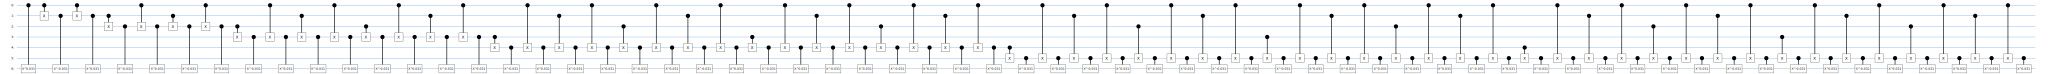


Gates used in construction
{2: 125}


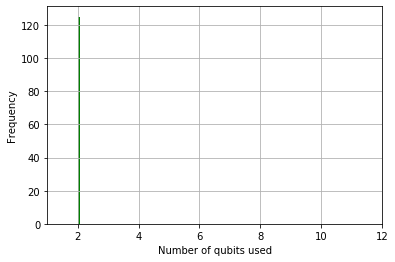


Shape= (128, 128)

C6Not unitary:
max_diag=1.0000000000000009 min_diag=1.0 max_off=0.0 min_off=-8.847089727481716e-16
The controlled gate in detail
U[126][126]= (-8.365703962898152e-16+1.3183898417423734e-16j) U[126][127]= (1.0000000000000004-9.676504389433127e-18j)
U[127][126]= (1.0000000000000004-9.676504389433127e-18j) U[127][127]= (-8.365703962898152e-16+1.3183898417423734e-16j)


In [ ]:
#@title
def test_Cn_gates():
   
    while True:
        n = input('Enter [X|Z] number of control lines: ')
        n = n.upper()
        mode = 'Not'
        if n[0] == 'Z':
            mode = 'Z'
            n    = n[1:]
        elif n[0] == 'X':
            n    = n[1:]

        if not n.isdigit():
            print(n, ' is not an integer')
            continue
        n = int(n)
        if n < 1:
            print(n, ' is not positive')
            continue
        if n > 10:
            print('Be reasonable (n <= 10)')
            continue
        break

    qubits = cirq.LineQubit.range(n+1)
    
    qx    = qubits[n] # Target of operation
    q0     = qubits[0]
    if n > 1:
        q1 = qubits[1]
    if n > 2:
        q2 = qubits[2]
    if n > 3:
        q3 = qubits[3]
    if n > 4:
        q4 = qubits[4]
    if n > 5:
        q5 = qubits[5]
    if n > 6:
        q6 = qubits[6]
    if n > 7:
        q7 = qubits[7]
    if n > 8:
        q8 = qubits[8]
    if n > 9:
        q9 = qubits[9]
   
    ops   = get_Cn_gates(n, mode)

    print("\nGates as text that can be generated by cirq using eval():")
    print(get_Cn_gates(n, mode))

    gates = eval(ops)
        
    circuit = cirq.Circuit()
    circuit.append(gates)
    
    print(f'\nC{n}{mode} Circuit:')
    svgprint(circuit)

    print('\nGates used in construction')
    count_gates_in_circuit(circuit)

    unitary = circuit.unitary()
    show_control_unitary(f'C{n}{mode}', unitary)

test_Cn_gates()

## Demonstrate how the Householder Transform is constructed

To construct $2|0_{m}><0_{m}| - I_{m×m}$

![Transform](https://cs.uwaterloo.ca/~ijdavis/qic895/transform.jpg)

There is little point in attempting to use a quantum computer to solve exponential problems, if that solution in turn requires implementation of an exponential number of gates. Since the number of gates to implement a $C_{m-1}Z$ operation is ~$2^{m}$ which is exponential, our solution must scale even for large $m$. Ancillary qubits can be exploited to permits this through a divide and conquer strategy. 

One ancillary qubit permits us to implement a $C_{5}X$ operation that sets the ancillary *qx* to 1 when qubits q1,q2,q3,q4,q5 are all 1, and a $C_{5}Z$ operation that performs the Z operation on qubit q0 when qubits qx,q6,q7,q8,q9 are all 1. As earlier noted, we must be careful to leave ancillary qubits |0>.

Also note that ZXZX (as well as XZXZ, YXYX, XYXY, YZYZ and ZYZY) negates all amplitudes. It negates all amplitudes when the line applied to has value |1> and then negates all amplitudes when the line has value |0>. Since the line must be in some superposition of |0> and |1> it negates all amplitudes. 

When the negation of all values must be controlled by using many gates consider using a single cirq.rz(*2 math.Pi*) gate, rather than ZXZX since this gate has the form *-I* and thus negates irrespective of what superposition the qubit operated on has.  This replaces ZXZX above with just a single gate.

https://arxiv.org/pdf/quant-ph/9503016.pdf (page 17)


Householder Circuit:


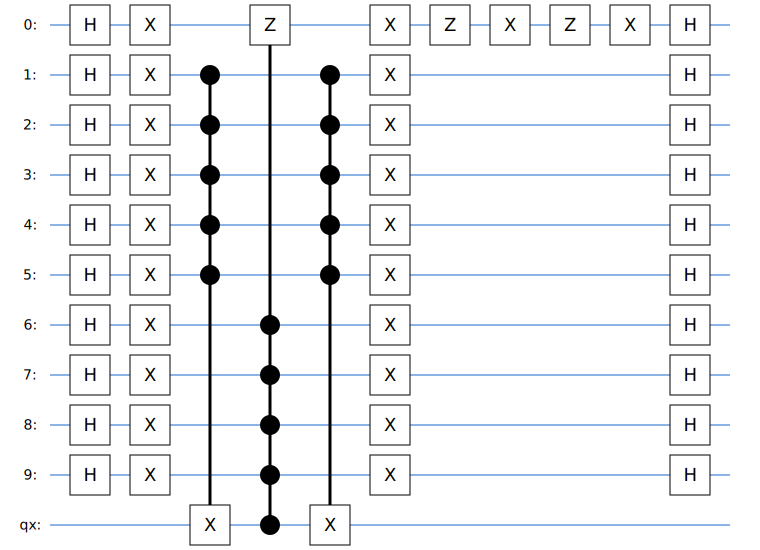


Shape= (2048, 2048)

Gates in circuit
{1: 44, 6: 3}


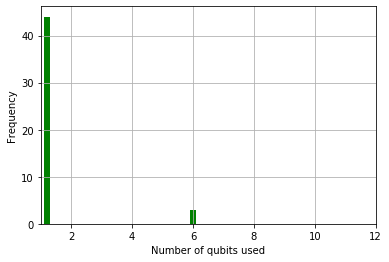


For comparison we earlier saw:
 (2/n)-1=-0.998046875 2/n=0.001953125
max_diag= -0.998046875  min_diag= -0.998046875  max_off= 0.001953125  min_off= 0.001953125

Householder unitary:
max_diag= (-0.9980468750000003+0j)  min_diag= (-0.9980468750000003+0j)  max_off= (0.0019531250000000013+0j)  min_off= (0.0019531249999998588+0j)


In [ ]:
#@title
# Create the global variables used

input_qubits = 10
extra_qubits = 1
total_qubits = input_qubits + extra_qubits

qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

qx     = cirq.NamedQubit('qx')  # One ancillary qubit

circuit = cirq.Circuit()

# Create an equi-superposition of all states
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.H(qubits[qubit]))
circuit.append(gates)

# X all input lines
# This is because our control operations are on lines being 1 (not 0)
# N.B. the C5Z operation requires that q0 is also X'd
# We want to target 0b0000000000 not 0b1000000000
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.X(qubits[qubit]))
circuit.append(gates)

# Set qx if q1 and q2 and q3 and q4 and q5
circuit.append(C5XGate().on(q1,q2,q3,q4,q5,qx), strategy=cirq.InsertStrategy.NEW)
# Negate just state 0               
circuit.append(C5ZGate().on(qx,q6,q7,q8,q9,q0), strategy=cirq.InsertStrategy.NEW)
# Restore qx to 0 for subsequent reuse
# N.B. This operation must be repeated at every iteration of Grover's algorithm
circuit.append(C5XGate().on(q1,q2,q3,q4,q5,qx), strategy=cirq.InsertStrategy.NEW)

# Restore all lines by undoing the earlier X performed on all lines
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.X(qubits[qubit]))
circuit.append(gates,strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Negate every state
# Each of ZXZX, YXYX, XZXZ, YZYZ, XYZY and ZYZY on any one line negate all amplitudes. 
circuit.append([cirq.Z(q0),cirq.X(q0),cirq.Z(q0),cirq.X(q0)], strategy=cirq.InsertStrategy.NEW) 

gates = []
# Now undo the creation of the equi-superposition
# The negated amplitude of |0> will do its amazing magic
for qubit in range(input_qubits):
    gates.append(cirq.H(qubits[qubit]))
circuit.append(gates, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    
print('\nHouseholder Circuit:')
svgprint(circuit)

show_grover_unitary('Grover1', circuit.unitary(), 2)



## For interest the alternative single C9Z solution

This requires many more gates to implement, but avoids the use of an ancillary qubit.  Where as 3 x 6 qubit gates requires approximately $3*2^{6}=192$ gates, the single 10 qubit gate requires approximately $2^{10}=1024$ gates.


Householder Circuit:


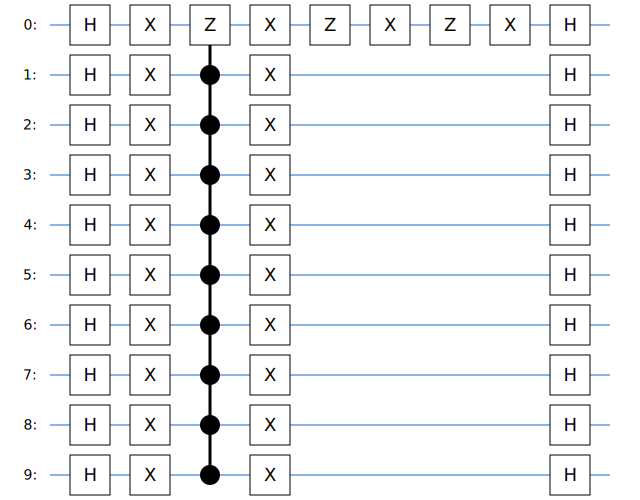


Shape= (1024, 1024)

Gates in circuit
{1: 44, 10: 1}


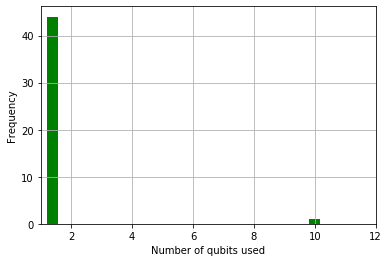


For comparison we earlier saw:
 (2/n)-1=-0.998046875 2/n=0.001953125
max_diag= -0.998046875  min_diag= -0.998046875  max_off= 0.001953125  min_off= 0.001953125

Householder unitary:
max_diag= (-0.9980468750000003+0j)  min_diag= (-0.9980468750000003+0j)  max_off= (0.0019531250000000013+0j)  min_off= (0.0019531249999998588+0j)


In [ ]:
#@title
# Create the global variables used

input_qubits = 10
extra_qubits = 0
total_qubits = input_qubits + extra_qubits

qubits = cirq.LineQubit.range(input_qubits)
q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

circuit = cirq.Circuit()

# Create an equi-superposition of all states
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.H(qubits[qubit]))
circuit.append(gates)

# X all input lines
# This is because our control operations are on lines being 1 (not 0)
# N.B. the C9Z operation requires that q0 is also X'd
# We want to target 0b0000000000 not 0b1000000000
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.X(qubits[qubit]))
circuit.append(gates)

# Negate just state 0  
circuit.append(C9ZGate().on(q1,q2,q3,q4,q5,q6,q7,q8,q9,q0), strategy=cirq.InsertStrategy.NEW)
             
# Restore all lines by undoing the earlier X performed on all lines
gates = []
for qubit in range(input_qubits):
    gates.append(cirq.X(qubits[qubit]))
circuit.append(gates,strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Negate every state
# Each of ZXZX, YXYX, XZXZ, YZYZ, XYZY and ZYZY on any one line negate all amplitudes. 
circuit.append([cirq.Z(q0),cirq.X(q0),cirq.Z(q0),cirq.X(q0)], strategy=cirq.InsertStrategy.NEW) 

gates = []
# Now undo the creation of the equi-superposition
# The negated amplitude of |0> will do its amazing magic
for qubit in range(input_qubits):
    gates.append(cirq.H(qubits[qubit]))
circuit.append(gates, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    
print('\nHouseholder Circuit:')
svgprint(circuit)

show_grover_unitary('Grover2', circuit.unitary(), 1)
 

# How you build the Oracle is your story to tell


## A classical simulation of 3-SAT

This example suggests how 3-SAT (which was the first NP-complete problem to be discovered) might be solved using Grover's algorithm. It internally uses only classical logic.

Hidden value: 0x17e and possibly others

What the Oracle is computing:

 (~p9∨~p8∨~p7)∧( p9∨ p8∨~p6)∧( p9∨~p7∨ p6)∧( p8∨~p7∨~p6)∧( p9∨ p8∨~p5)∧( p9∨~p7∨ p5)∧( p8∨~p7∨~p5)∧( p9∨ p6∨~p5)
∧(~p8∨~p6∨ p5)∧( p7∨~p6∨~p5)∧( p9∨ p8∨~p4)∧( p9∨~p7∨ p4)∧( p8∨~p7∨~p4)∧( p9∨ p6∨~p4)∧(~p8∨~p6∨ p4)∧( p7∨~p6∨~p4)
∧( p9∨ p5∨~p4)∧(~p8∨~p5∨ p4)∧( p7∨~p5∨~p4)∧(~p6∨ p5∨~p4)∧( p9∨~p8∨ p3)∧(~p9∨~p7∨~p3)∧(~p8∨ p7∨~p3)∧( p9∨~p6∨ p3)
∧( p8∨~p6∨~p3)∧(~p7∨ p6∨~p3)∧( p9∨~p5∨ p3)∧( p8∨~p5∨~p3)∧(~p7∨ p5∨~p3)∧(~p6∨~p5∨ p3)∧(~p9∨~p4∨~p3)∧(~p8∨ p4∨~p3)
∧(~p7∨~p4∨ p3)∧( p6∨~p4∨~p3)∧(~p5∨ p4∨~p3)∧( p9∨~p8∨~p2)∧(~p9∨~p7∨ p2)∧(~p8∨ p7∨ p2)∧( p9∨~p6∨~p2)∧( p8∨~p6∨ p2)
∧(~p7∨ p6∨ p2)∧( p9∨~p5∨~p2)∧( p8∨~p5∨ p2)∧(~p7∨ p5∨ p2)∧(~p6∨~p5∨~p2)∧(~p9∨~p4∨ p2)∧(~p8∨ p4∨ p2)∧(~p7∨~p4∨~p2)
∧( p6∨~p4∨ p2)∧(~p5∨ p4∨ p2)∧( p9∨~p3∨~p2)∧( p8∨~p3∨ p2)∧(~p7∨ p3∨ p2)∧(~p6∨~p3∨~p2)∧( p5∨~p3∨ p2)∧(~p4∨ p3∨ p2)
∧( p9∨~p8∨ p1)∧(~p9∨~p7∨~p1)∧(~p8∨ p7∨~p1)∧( p9∨~p6∨ p1)∧( p8∨~p6∨~p1)∧(~p7∨ p6∨~p1)∧( p9∨~p5∨ p1)∧( p8∨~p5∨~p1)
∧(~p7∨ p5∨~p1)∧(~p6∨~p5∨

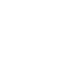

In [ ]:
#@title
num_values = 1
hidden_values = []
assign_hidden_values(hidden_values)
value = hidden_values[0]

print(f'Hidden value: 0x{value:x} and possibly others')

sat     = '\n'
prefix  = ' ('
clauses = 0
right   = 0
for set_bits in range(1024):
    parity    = 0
    set_bits1 = set_bits
    while True:
        low_bit = set_bits1 & -set_bits1
        if low_bit == 0:
            break
        parity = parity + 1
        if parity > 3:
            break
        set_bits1 &= ~low_bit
    if parity != 3:
       continue
    sat    += prefix
    prefix1 = ''
    set_bits1 = set_bits
    predicate = 0
    while True:
        low_bit = set_bits1 & -set_bits1
        if low_bit == 0:
            break
        set_bits1 &= ~low_bit
        if predicate == right:
            if value & low_bit:
                negate = ' '
            else:
                negate = '~'
        else:
            if value & low_bit:
                negate = '~'
            else:
                negate = ' '

        p          = 9
        while True:
            low_bit >>= 1
            if low_bit == 0:
                break
            p -= 1
        sat += prefix1 + negate+'p' + str(p)
        prefix1 = '∨'
        predicate += 1
    sat += ')'
    right += 1
    if right == 3:
        right = 0
    prefix = '∧(' 
    clauses += 1
    if not clauses % 8:
        sat += '\n'
print('\nWhat the Oracle is computing:')
print(sat)

print('Our input is a equi-superposition of all possible predicate assignments')
print("\nAfter amplification each output line represents a predicate:\n")
cmd = ''
for p in range(10):
    low_bit = (value & (1<<(9-p)))
    if low_bit != 0:
        low_bit = 1
    stmt = f'p{p} = {low_bit==1} # |{low_bit}>'
    print(stmt)
    cmd += stmt + '\n'

exec(cmd)

sat = sat.replace('∧',' and ')
sat = sat.replace('∨',' or ')
sat = sat.replace('~',' not ')
sat = sat.replace('\n', '')
print('\nTest the value measured\n')
ok = eval(sat)
print(f'eval(sat): ', ok)
if ok:
    yes_answer()
else:
    no_answer()

## A complete Unique-SAT quantum solution

### Functions used

In [ ]:
#@title

cnot = ['cirq.X', 'cirq.CX', 'cirq.CCX', 'C3XGate().on', 'C4XGate().on', 'C5XGate().on', 'C6XGate().on']
cz   = ['cirq.Z', 'cirq.CZ', 'cirq.CCZ', 'C3ZGate().on', 'C4ZGate().on', 'C5ZGate().on', 'C6ZGate().on']

# Return a randomly constructed SAT expression that has one solution
# We start with all possible patterns and eliminating patterns while there is more than 1
def generate_unique_sat(dimension):
    global hidden_values

    hidden_values = []

    size      = 2**dimension
    for i in range(size):
        hidden_values.append(i)
    valid_cnt = size
    sat       = [] 
    while valid_cnt > 1:
        p1 = random.randint(0, dimension-1)
        p2 = random.randint(0, dimension-1)
        if p1 == p2:
            continue
        p3 = random.randint(0, dimension-1)
        if p3 == p1 or p3 == p2:
            continue
        # want predicate 0 to be most significant bit (not least)
        p1r = dimension - p1 - 1
        p2r = dimension - p2 - 1
        p3r = dimension - p3 - 1
        
        n1  = random.randint(0,1)
        n2  = random.randint(0,1)
        n3  = random.randint(0,1)
        cnt = 0 
        for i in range(valid_cnt):
            value = hidden_values[i]
            if n1 == ((value>>p1r)&1) and n2 == ((value>>p2r)&1) and n3 == ((value>>p3r)&1):
                cnt += 1
        if cnt == 0 or cnt == valid_cnt:
            continue
        for i in range(valid_cnt-1,-1,-1):
            value = hidden_values[i]
            if n1 == ((value>>p1r)&1) and n2 == ((value>>p2r)&1) and n3 == ((value>>p3r)&1):
                hidden_values.pop(i)
        # predicate 0 is most significant bit -- 
        sat.append([[n1,n2,n3],[p1,p2,p3]])
        valid_cnt -= cnt
    return sat

# Convert the sat expression to text
def sat_expression(sat):

    ret = ''
    for i in range(len(sat)):
        clause = sat[i]
        n      = clause[0]
        p      = clause[1]

        if i != 0:
            ret += 'and '
        ret += '('
        for j in range(3):
            if j != 0:
                ret += 'or '
            if n[j] != 0:
                ret += 'not '
            ret += f'p{p[j]} '
        ret += ')\n'
    return ret

def highlight(output):
    print(color.BOLD, color.BLUE, output, color.END)

# Show the element of the vector
def show_element(vector, entry):
    global copy_qubits, flag_qubits, extra_qubits

    amplitude  = vector[entry].real
    # amplitude2 = amplitude * numpy.conj(amplitude)
    lines      = entry>>(count_qubits + extra_qubits)
    linesc     = (entry>>extra_qubits)&((1 << count_qubits)-1)
    extra      = entry & ((1 << extra_qubits)-1)
        
    if (amplitude == 1.0):
        print('+')
    elif amplitude == -1.0:
        print('-', end='')
    elif amplitude == 0.0:
        print('+0', end='')
    else:
        print(f'{amplitude:+.8f}', end='')
    if input_qubits != 0:
        print(f'|{lines:>03x}>', end='')
    if count_qubits != 0:
        print(f'|{linesc:>02x}>', end='')
    if extra_qubits != 0:
        print(f'|{extra:>1x}>', end='')

# Show those elements in the vector with maximum satisfied clauses
def show_max_count(vector):
    global count_qubits, extra_qubits

    max_count = 0
    for entry in range(len(vector)):
        amplitude = vector[entry].real
        if amplitude == 0:
            continue
        count = (entry >> extra_qubits) & ((1<<count_qubits)-1)
        if max_count < count:
            max_count = count

    if max_count == 0:
        return

    print('Max count: ', end='')
    for entry in range(len(vector)):
        amplitude = vector[entry].real
        if amplitude == 0:
            continue
        count = (entry >> extra_qubits) & ((1<<count_qubits)-1)
        if max_count == count:
            show_element(vector, entry)
    print('')

# A display action that is embedded in the circuit as an identity operation
# When invoked it shows the maximum count in the state vector
class ShowCntGate(cirq.ops.raw_types.Gate):
   
    def _num_qubits_(self):
        return 1

    def __init__(self):
        self.showCnt = True
                
    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:
        global vector, do_run

        if not do_run and self.showCnt:
            show_max_count(vector)
            self.showCnt = False
              
        return cirq.protocols.apply_unitary(
            cirq.I,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    # This function is used when we really need the quantum gates to proceed
    # That occurs when we are genuinely running on a quantum computer
    def _decompose_(self, qubits):
        return cirq.I(qubits[0])

    # This function is used to pretty print this gate in a circuit diagram
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        if self.showCnt:
            name = 'ShowCnt'
        else:
            name = 'I'
        return cirq.protocols.CircuitDiagramInfo(
            [name],
            exponent=1)

    # This function is used to generate assembler for the circuit
    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    # This function is supposed to return something that evals to this gate
    def __repr__(self) -> str:
        return 'ShowCntGate'
 
    def __str__(self) -> str:
        return 'ShowCntGate'

# Show the state vector highlighting in red changes
def show_dirac(old_vector, vector):

    count = 0
    for entry in range(len(vector)):
        amplitude = vector[entry].real
        same      = (old_vector[entry].real == amplitude)
        if amplitude != 0:
            count += 1
            if count > 2048:
                print(' ...', end='')
                break
            if not same:
                print(color.RED, end='')
            else:
                print(color.BLUE, end='')
            show_element(vector,entry)
            print(color.END, end='')
        old_vector[entry] = amplitude
    print('')

# Another display gate that shows a comment and the state
class CommentGate(cirq.ops.raw_types.Gate):
   
    def _num_qubits_(self):
        return 1

    def __init__(self, comment):
        self.comment      = comment
                
    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:
        global vector, old_vector

        comment      = self.comment
        self.comment = ''
        if not do_run and comment != '':
            highlight(f'{comment}')
            show_dirac(old_vector, vector)   
       
        return cirq.protocols.apply_unitary(
            cirq.I,
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    # This function is used when we really need the quantum gates to proceed
    # That occurs when we are genuinely running on a quantum computer
    def _decompose_(self, qubits):
        # print(f'Comment [decompose]: {self.comment}')
        return cirq.I(qubits[0])

    # This function is used to pretty print this gate in a circuit diagram
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        if self.comment != '':
            name = 'Cmt'
        else:
            name = 'I'
        return cirq.protocols.CircuitDiagramInfo(
            [name],
            exponent=1)

    # This function is used to generate assembler for the circuit
    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    # This function is supposed to return something that evals to this gate
    def __repr__(self) -> str:
        return 'CommentGate'
 
    def __str__(self) -> str:
        return 'CommentGate'

# Code to generate an array of rotations to be performed in order to discover when all clauses are satisfied. 
# The idea is simple. After n clauses have all be satisfied all clauses can only be satisfied if the count is n. 
# So set qs if a clause is satisfied and count is n. Then increment the count conditional on ps being true. 
# Finally clear qs if count is now n+1.

def construct_quantum_counter():
    global count_qubits

    print('increment_actions = [')

    sep       = ' '
    lines     = count_qubits
    for cnt in range((1 << lines)-1):
    
        print(f'{sep}\'[',end='')
        for i in range(lines):
            if (cnt & (1<<i)) == 0:
                target = i
                break

        # Either set to 1 or make number smaller
        if target == 0:
            print(f'cirq.CX(qr,qc[{lines-target-1}])]\' # {cnt}->{cnt+1}')
            sep = ','
            continue

        bits = 0
        for i in range(lines):
            if (cnt & (1<<i)) != 0:
                bits += 1

        print(f'{cnot[bits+1]}(qr', end='')  
        for i in range(6):
            if (cnt & (1<<i)) != 0:
                print(f',qc[{lines-i-1}]', end='')
        print(f',qs)', end = '')
        for invert in range(target+1):
            print(f',cirq.CX(qs,qc[{lines-invert-1}])', end='')
    
        cnt1 = cnt + 1
        bits = 0
        for i in range(lines):
            if (cnt1 & (1<<i)) != 0:
                bits += 1
        print(f',{cnot[bits]}(', end='')
        for i in range(lines):
            if (cnt1 & (1<<i)) != 0:
                print(f'qc[{lines-i-1}],', end='')
        print(f'qs)]\' # {cnt}->{cnt1}')

    print(']')
         
# qc[0] is most significant and qc[5] is least significant bit if counter uses 6 lines
increment_actions = [
 '[cirq.CX(qr,qc[5])]' # 0->1
,'[cirq.CCX(qr,qc[5],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qc[4],qs)]' # 1->2
,'[cirq.CX(qr,qc[5])]' # 2->3
,'[C3XGate().on(qr,qc[5],qc[4],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qc[3],qs)]' # 3->4
,'[cirq.CX(qr,qc[5])]' # 4->5
,'[C3XGate().on(qr,qc[5],qc[3],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CCX(qc[4],qc[3],qs)]' # 5->6
,'[cirq.CX(qr,qc[5])]' # 6->7
,'[C4XGate().on(qr,qc[5],qc[4],qc[3],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CX(qc[2],qs)]' # 7->8
,'[cirq.CX(qr,qc[5])]' # 8->9
,'[C3XGate().on(qr,qc[5],qc[2],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CCX(qc[4],qc[2],qs)]' # 9->10
,'[cirq.CX(qr,qc[5])]' # 10->11
,'[C4XGate().on(qr,qc[5],qc[4],qc[2],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CCX(qc[3],qc[2],qs)]' # 11->12
,'[cirq.CX(qr,qc[5])]' # 12->13
,'[C4XGate().on(qr,qc[5],qc[3],qc[2],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[3],qc[2],qs)]' # 13->14
,'[cirq.CX(qr,qc[5])]' # 14->15
,'[C5XGate().on(qr,qc[5],qc[4],qc[3],qc[2],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CX(qs,qc[1]),cirq.CX(qc[1],qs)]' # 15->16
,'[cirq.CX(qr,qc[5])]' # 16->17
,'[C3XGate().on(qr,qc[5],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CCX(qc[4],qc[1],qs)]' # 17->18
,'[cirq.CX(qr,qc[5])]' # 18->19
,'[C4XGate().on(qr,qc[5],qc[4],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CCX(qc[3],qc[1],qs)]' # 19->20
,'[cirq.CX(qr,qc[5])]' # 20->21
,'[C4XGate().on(qr,qc[5],qc[3],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[3],qc[1],qs)]' # 21->22
,'[cirq.CX(qr,qc[5])]' # 22->23
,'[C5XGate().on(qr,qc[5],qc[4],qc[3],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CCX(qc[2],qc[1],qs)]' # 23->24
,'[cirq.CX(qr,qc[5])]' # 24->25
,'[C4XGate().on(qr,qc[5],qc[2],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[2],qc[1],qs)]' # 25->26
,'[cirq.CX(qr,qc[5])]' # 26->27
,'[C5XGate().on(qr,qc[5],qc[4],qc[2],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),C3XGate().on(qc[3],qc[2],qc[1],qs)]' # 27->28
,'[cirq.CX(qr,qc[5])]' # 28->29
,'[C5XGate().on(qr,qc[5],qc[3],qc[2],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C4XGate().on(qc[4],qc[3],qc[2],qc[1],qs)]' # 29->30
,'[cirq.CX(qr,qc[5])]' # 30->31
,'[C6XGate().on(qr,qc[5],qc[4],qc[3],qc[2],qc[1],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CX(qs,qc[1]),cirq.CX(qs,qc[0]),cirq.CX(qc[0],qs)]' # 31->32
,'[cirq.CX(qr,qc[5])]' # 32->33
,'[C3XGate().on(qr,qc[5],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CCX(qc[4],qc[0],qs)]' # 33->34
,'[cirq.CX(qr,qc[5])]' # 34->35
,'[C4XGate().on(qr,qc[5],qc[4],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CCX(qc[3],qc[0],qs)]' # 35->36
,'[cirq.CX(qr,qc[5])]' # 36->37
,'[C4XGate().on(qr,qc[5],qc[3],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[3],qc[0],qs)]' # 37->38
,'[cirq.CX(qr,qc[5])]' # 38->39
,'[C5XGate().on(qr,qc[5],qc[4],qc[3],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CCX(qc[2],qc[0],qs)]' # 39->40
,'[cirq.CX(qr,qc[5])]' # 40->41
,'[C4XGate().on(qr,qc[5],qc[2],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[2],qc[0],qs)]' # 41->42
,'[cirq.CX(qr,qc[5])]' # 42->43
,'[C5XGate().on(qr,qc[5],qc[4],qc[2],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),C3XGate().on(qc[3],qc[2],qc[0],qs)]' # 43->44
,'[cirq.CX(qr,qc[5])]' # 44->45
,'[C5XGate().on(qr,qc[5],qc[3],qc[2],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C4XGate().on(qc[4],qc[3],qc[2],qc[0],qs)]' # 45->46
,'[cirq.CX(qr,qc[5])]' # 46->47
,'[C6XGate().on(qr,qc[5],qc[4],qc[3],qc[2],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),cirq.CX(qs,qc[1]),cirq.CCX(qc[1],qc[0],qs)]' # 47->48
,'[cirq.CX(qr,qc[5])]' # 48->49
,'[C4XGate().on(qr,qc[5],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C3XGate().on(qc[4],qc[1],qc[0],qs)]' # 49->50
,'[cirq.CX(qr,qc[5])]' # 50->51
,'[C5XGate().on(qr,qc[5],qc[4],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),C3XGate().on(qc[3],qc[1],qc[0],qs)]' # 51->52
,'[cirq.CX(qr,qc[5])]' # 52->53
,'[C5XGate().on(qr,qc[5],qc[3],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C4XGate().on(qc[4],qc[3],qc[1],qc[0],qs)]' # 53->54
,'[cirq.CX(qr,qc[5])]' # 54->55
,'[C6XGate().on(qr,qc[5],qc[4],qc[3],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),cirq.CX(qs,qc[2]),C3XGate().on(qc[2],qc[1],qc[0],qs)]' # 55->56
,'[cirq.CX(qr,qc[5])]' # 56->57
,'[C5XGate().on(qr,qc[5],qc[2],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C4XGate().on(qc[4],qc[2],qc[1],qc[0],qs)]' # 57->58
,'[cirq.CX(qr,qc[5])]' # 58->59
,'[C6XGate().on(qr,qc[5],qc[4],qc[2],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),cirq.CX(qs,qc[3]),C4XGate().on(qc[3],qc[2],qc[1],qc[0],qs)]' # 59->60
,'[cirq.CX(qr,qc[5])]' # 60->61
,'[C6XGate().on(qr,qc[5],qc[3],qc[2],qc[1],qc[0],qs),cirq.CX(qs,qc[5]),cirq.CX(qs,qc[4]),C5XGate().on(qc[4],qc[3],qc[2],qc[1],qc[0],qs)]' # 61->62
,'[cirq.CX(qr,qc[5])]' # 62->63
]

# Define the Oracle so that it encodes its single result as
# separate actions across successive pairs of lines
class OracleSATGate(cirq.ops.raw_types.Gate):
    def num_qubits(self) -> int:
        global total_qubits
        
        return total_qubits
                         
    def __init__(self, sat):
        self.sat   = sat
 
    def qubit_index_to_equivalence_group_key(self, index):
        # Order of arguments is significant
        return False

    def _decompose_(self, qubits):
        global QR, QS, input_qubits, count_qubits, total_qubits

        # Extract the counter qubits 
        qc = []
        for i in range(count_qubits):
            qc.append(qubits[input_qubits + i])

        gates = []
        
        # Count satisfied clauses
        qr      = qubits[total_qubits-2]
        qs      = qubits[total_qubits-1]
        sat     = self.sat
        clauses = len(sat)
        for cnt in range(clauses):
            clause = sat[cnt]
            n      = clause[0]
            p      = clause[1]
            for i in range(3):
                if n[i] == 0:
                    gates.append(cirq.X(qubits[p[i]])) #Test 3 predicates false
            gates.append(cirq.X(qr)) # Set qr |1>
            p0     = qubits[p[0]]
            p1     = qubits[p[1]]
            p2     = qubits[p[2]]
            gates.append(C3XGate().on(p0,p1,p2,qr)) # Clear qr if false
            # If not all three tests failed
            # Make cnt -> cnt+1

            if len(increment_actions) <= cnt:
                print('**OVERFLOW**')
                return
            action = eval(increment_actions[cnt])
            for item in action:
                # Avoid any nested lists in the gates
                # They screw up computing the inverse through reversal
                gates.append(item)
            
            # Clear qr
            gates.append(C3XGate().on(p0,p1,p2,qr))
            gates.append(cirq.X(qr)) # Set qr |0>

            for i in range(3):
                if n[i] == 0:
                    gates.append(cirq.X(qubits[p[i]])) # Clear negation

        # Negate this pattern if and only if all clauses are satisfied
        # In this case the count is the same as the number of clauses
        bits = 0
        for i in range(6):
            if (clauses & (1<<i)) != 0:
                bits += 1
        cmd = f'{cz[bits-1]}('
        sep = ''
        for i in range(6):
            if (clauses & (1<<i)) != 0:
                bit  = count_qubits-i-1
                cmd += f'{sep}qc[{bit}]'
                sep  = ','
        cmd += ')'

        lth  = len(gates)
        gates.append(eval(cmd))
        gates.append(ShowCntGate().on(qc[bit]))
 
        # Reverse out all reversable actions except for setting qs
        # For this to work we must not have any nested lists
        while lth > 0:
            lth -= 1
            gates.append(gates[lth])
        # gates.append(CommentGate('After Oracle').on(qr))
        return gates
      
    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        global input_qubits, count_qubits, total_qubits

        info = []
        if len(self.sat) == 0:
            for i in range(total_qubits):
                info.append('I')   
        else:
            for i in range(input_qubits):
                info.append('O')
            for i in range(count_qubits):
                info.append(f'C{i}')
            info.append('QR')
            info.append('QS')
        return cirq.protocols.CircuitDiagramInfo(
            info,
            exponent=1)

    def __repr__(self) -> str:
        return 'OracleSATGate'
 
    def __str__(self) -> str:
        return 'OracleSATGate'

print('Oracle defined')


Oracle defined


### Run


Hidden: 0x1e8 number clauses: 23

(not p8 or not p5 or not p2 )
and (p4 or p3 or p8 )
and (p7 or not p5 or p0 )
and (not p1 or p4 or not p7 )
and (p7 or p1 or p9 )
and (not p4 or not p1 or p3 )
and (p9 or not p5 or p2 )
and (not p5 or p2 or p0 )
and (p1 or not p9 or not p0 )
and (not p0 or p8 or p5 )
and (p5 or not p8 or not p9 )
and (p0 or not p4 or p6 )
and (p6 or not p3 or p1 )
and (not p9 or p8 or p2 )
and (p5 or not p0 or p6 )
and (p0 or not p5 or not p9 )
and (not p5 or p6 or not p9 )
and (p0 or p7 or not p8 )
and (p2 or p4 or not p5 )
and (not p1 or p4 or p2 )
and (p3 or p5 or not p6 )
and (not p7 or not p3 or not p6 )
and (not p2 or not p9 or p0 )
and (not p9 or not p0 or p2 )
and (not p4 or p8 or not p9 )
and (not p0 or not p7 or not p5 )
and (not p6 or not p5 or p9 )
and (not p7 or p2 or p5 )
and (p9 or p2 or not p6 )
and (p1 or p3 or p6 )
and (not p1 or not p9 or not p6 )
and (not p3 or p6 or p5 )
and (not p5 or p7 or not p1 )
and (not p4 or p9 or not p0 )
and (p4 or not p3

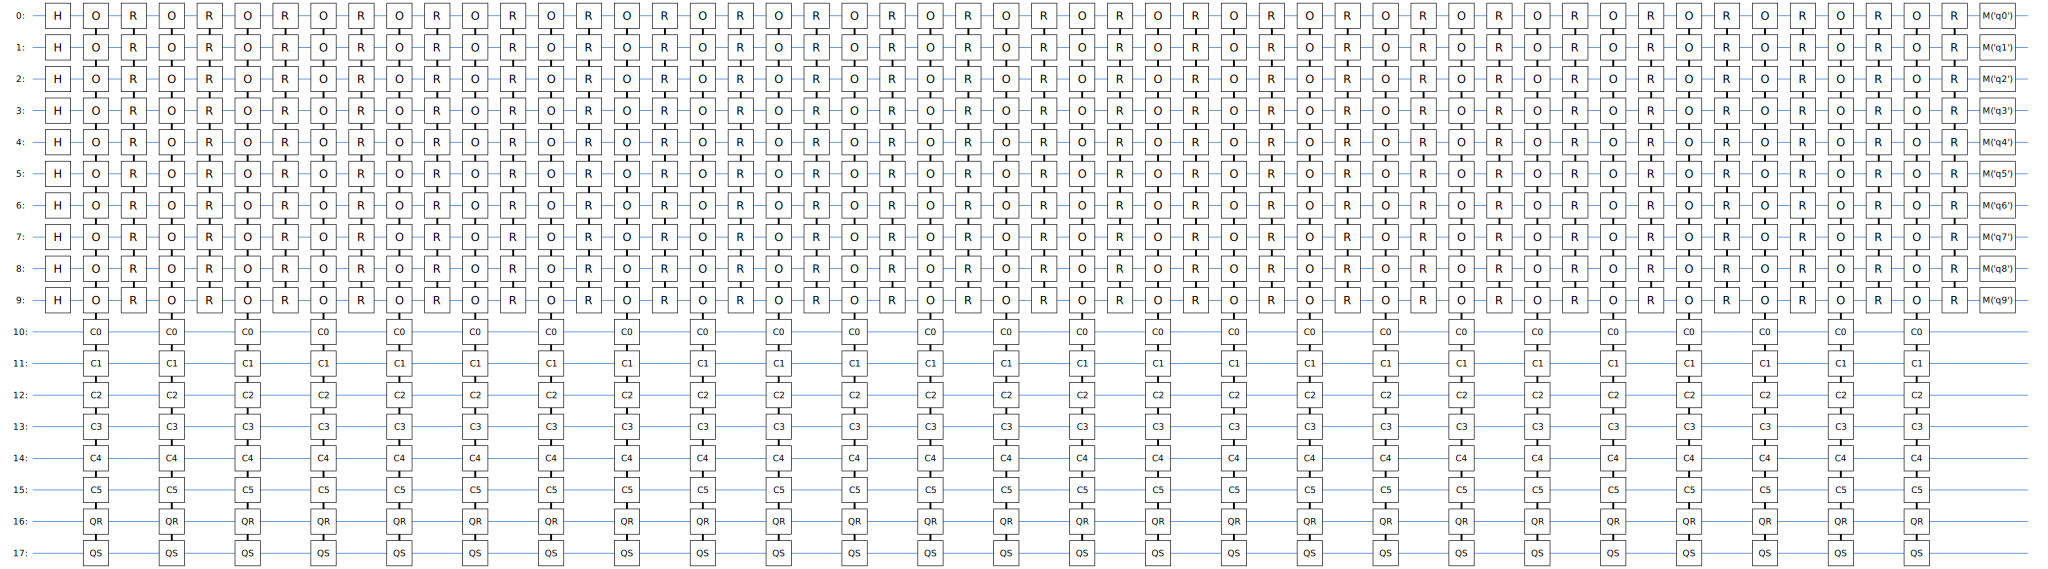

Max count: -0.03125000|1e8>|23>|0>
Max count: -0.09362792|1e8>|23>|0>
Max count: -0.15564013|1e8>|23>|0>
Max count: -0.21704429|1e8>|23>|0>
Max count: -0.27760035|1e8>|23>|0>
Max count: -0.33707142|1e8>|23>|0>
Max count: -0.39522654|1e8>|23>|0>
Max count: -0.45183760|1e8>|23>|0>
Max count: -0.50668418|1e8>|23>|0>
Max count: -0.55955040|1e8>|23>|0>
Max count: -0.61023146|1e8>|23>|0>
Max count: -0.65853065|1e8>|23>|0>
Max count: -0.70425606|1e8>|23>|0>
Max count: -0.74722904|1e8>|23>|0>
Max count: -0.78728521|1e8>|23>|0>
Max count: -0.82426655|1e8>|23>|0>
Max count: -0.85802668|1e8>|23>|0>
Max count: -0.88843453|1e8>|23>|0>
Max count: -0.91537184|1e8>|23>|0>
Max count: -0.93873250|1e8>|23>|0>
Max count: -0.95842791|1e8>|23>|0>
Max count: -0.97437847|1e8>|23>|0>
Max count: -0.98652250|1e8>|23>|0>
Max count: -0.99481630|1e8>|23>|0>
Max count: -0.99922186|1e8>|23>|0>

After last step:
+0.99999356|1e8>|00>|0>
Measured 0x1e8 .v. hidden value 0x1e8 same

p0 = False # |0>
p1 = True # |1>
p2 = T

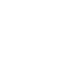

In [ ]:
#@title

input_qubits     = 10
count_qubits     = 6
extra_qubits     = 2
total_qubits     = input_qubits + count_qubits + extra_qubits

# Create the global variables used
qubits = cirq.LineQubit.range(total_qubits)

q0     = qubits[0]
q1     = qubits[1]
q2     = qubits[2]
q3     = qubits[3]
q4     = qubits[4]
q5     = qubits[5]
q6     = qubits[6]
q7     = qubits[7]
q8     = qubits[8]
q9     = qubits[9]

qc0    = qubits[10]
qc1    = qubits[11]
qc2    = qubits[12]
qc3    = qubits[13]
qc4    = qubits[14]
qc5    = qubits[15]

qr     = qubits[16]
qs     = qubits[17]

# Create a random unique sat
while True:
    sat = generate_unique_sat(input_qubits)
    if len(sat) < 2**count_qubits:
        # Can count clauses in count_qubits
        break

print(f'\nHidden: 0x{hidden_values[0]:x} number clauses: {len(sat):x}\n')

sat_text = sat_expression(sat)
print(sat_text)

circuit = cirq.Circuit()

gates   = []
# Perform H on all input lines
set_same_amplitudes(gates)

# Compute the optimal number of rotations for a single marked value
rotations   = int((math.pi/4) * math.sqrt(input_values/num_values))
print(f'\nOptimal Rotations/Iterations = (π/4)√(2^inputs) = (π/4)√(2^10) = {color.BOLD}{color.BLUE}{rotations}{color.END}')

# Perform the optimal number of rotations
for rotation in range(rotations):
   # Use the oracle to negate two bits of the answer in one of |0>,|1>,|2> or |3>
    gate = OracleSATGate(sat).on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,qc0,qc1,qc2,qc3,qc4,qc5,qr,qs)
    gates.append(gate)
    gate = HouseholderGate().on(q0,q1,q2,q3,q4,q5,q6,q7,q8,q9)
    gates.append(gate)

# Add all gates to circuit
circuit.append(gates)

# Measure inputs at end of execution
for qubit in range(input_qubits):
     circuit.append([cirq.measure(qubits[qubit], key=f'q{qubit}')])

print('\nGrover Circuit:')
svgprint(circuit)

# Simulate the circuit.
simulator  = cirq.Simulator()
do_run     = False
measured   = 0
old_vector   = numpy.zeros(1<<total_qubits)

if do_run:
    result       = simulator.simulate(circuit)
    measurements = result.measurements
    # Reconstruct the result measured
    for qubit in range(input_qubits):
        measured <<= 1
        measured  |= measurements['q'+str(qubit)][0]
    print("\nAfter run:")
    show_dirac(old_vector, result.final_state)
else:
 
    for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
        vector = step.state_vector()
                          
    measurements = step.measurements
    #print(measurements)
    # Reconstruct the result measured
    for qubit in range(input_qubits):
        measured <<= 1
        measured  |= measurements['q'+str(qubit)][0]
    print("\nAfter last step:")
    show_dirac(old_vector, vector)
    #describe_amplitudes(vector)

# Show result 
print(f'Measured {color.BOLD}{color.BLUE}0x{measured:x}{color.END}', end='')
if len(hidden_values) > 0:
    print(f' .v. hidden value {color.BOLD}{color.RED}0x{hidden_values[0]:x}{color.END}', end='')
    if measured ==hidden_values[0]:
        print(' same\n')
    else:
        print(f' {color.BOLD}{color.PURPLE}DIFFER!!{color.END}\n')

cmd = ''
for p in range(10):
    low_bit = (measured & (1<<(9-p)))
    if low_bit != 0:
        low_bit = 1
    stmt = f'p{p} = {low_bit==1} # |{low_bit}>'
    print(stmt)
    cmd += stmt + '\n'

exec(cmd)

print('\nTest the value measured\n')
sat_text = sat_text.replace('\n',' ')
ok = eval(sat_text)
print(f'eval(sat): {ok}')
if ok:
    yes_answer()
else:
    no_answer()


Always remember that the hidden value found by Grover's algorithm may be wrong.  Perhaps we got unlucky and measured a highly unlikely wrong value never flagged by the Oracle, or perhaps the number of rotations performed by Grover's algorithm was far from optimal.  Thus Grover's algorithm dictates that any value discovered be tested (efficiently) using classical means in order to validate that it indeed a legitimate solution to the problem posed.

# Concluding remarks

Grover's algorithm can solve search problems involving $n$ binary predicates such as 3-SAT in $O(√2^{n}) = O(2^{0.5n})$ time.  Unfortunately this offers no clear advantage over recent classical techniques for solving 3-SAT which can solve any satisfiable 3-SAT problem in the worst case with high probability in $O(2^{0.448n})$ time and when just one solution exists in $O(2^{0.387n})$ time.  &lsqb;Paturi]. 

Grover's algorithm can be efficiently simulated on a classical computer even when applied to many tens of lines (35 lines are used in empirical results) by representing the entire computation in terms of tensor product decompositions. This is because (assuming the Oracle also complies which ours does) it uses only single qubit gates, and arbitrary $C_{n}X$ and $C_{n}Z$ gates &lsqb;Kawaguchi]. It might thus become the case that Grover's algorithm becomes an important case study for both classical quantum simulation and genuine quantum computing. 

The quantum speed up achieved by Grover's algorithm is less impressive than for many quantum algorithms.  This is because it does not leverage quantum interference or employ a divide and conquer strategy either through parallel execution of the underlying algorithm across distinct subspaces to obtain results faster, or even within the single vector subspace it operates on. Instead at each iteration, it manipulates all amplitudes within this one vector subspace.  

It is the Quantum Oracle (in leveraging superposition to efficiently mark satisfying amplitudes) that provides much of the advantage of executing Grover's algorithm on a quantum computer. There may be some NP-hard problems for which no classical Oracle can compete with a quantum one simply because a quantum computer can examine all possible cases in $O(√2^{n})$ time irrespective of the problem domain.


# === REFERENCES ===

Aaronson, S. and Rall, P. "Quantum Approximation Counting, Simplified" https://arxiv.org/abs/1908.10846 2019

Barenco, A. et. al. "Elementary Gates for Quantum Computation" https://arxiv.org/abs/quant-ph/9503016 1995

Borbely, E. "Grover Search Algorithm" 2007 https://arxiv.org/abs/0705.4171

Brassard, G. et al. "Quantum Amplitude Amplification and Estimation" 2000 https://arxiv.org/abs/quant-ph/0005055

Cirq Developers "Cirq Documentation Release 0.8.0 Dev" page 53-55 https://readthedocs.org/projects/cirq/downloads/pdf/latest 

Deutsch, D. Lectures on Quantum Computing, Lecture 6 2003 http://www.quiprocone.org/Protected/DD_lectures.htm

Gross, M. and Stallard, J. "Implementing Grover’s algorithm using linear transformations in Haskell" https://pdfs.semanticscholar.org/7fbb/979764c2b43f37dfdaa556a13b31919fada0.pdf

Grover, L.K. "A fast quantum mechanical algorithm for database search". arXiv:quant-ph/9605043 1996 https://arxiv.org/abs/quant-ph/9605043

Grover, L.K. "Quantum Mechanics helps in searching for a needle in a haystack" 1997 https://arxiv.org/abs/quant-ph/9706033

Hidary, J. D. "Quantum Computing: An applied Approach", Pg 126-129, 2019.

Kaye, P. Laflamme R and Mosca, M. "An Introduction to Quantum Computing", Pg 152-169, 2010

Kawaguchi, A. et. al. "Classical Simulation of Quantum Algorithms using the Tensor Product Representation" https://arxiv.org/abs/quant-ph/0411205v2 2018.

Mermin, N. David, "Quantum Computer Science: An Introduction", Pg 89-98, 2007.

Nielsen, M. A. and Chuang, I. L, "Quantum Computation and Quantum Information", Pg 248-261, 2016

Paturi, R. et. al. "An improved exponential-time algorithm for k-SAT". https://https://cseweb.ucsd.edu/~paturi/myPapers/pubs/PaturiPudlakSaksZane_2005_jacm.pdf J ACM 52(3) 2005 337-364.

Ramos, R., Benicio de Sousa, P, Oliveira, D.S. "Solving Mathematical Problems with Quantum Search Algorithm" 2006 https://arxiv.org/abs/quant-ph/0605003

Wikipedia: https://en.wikipedia.org/wiki/Grover%27s_algorithm

---